# KITTI Odometry Dataset - Computer Vision
This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. This notebook pairs with a series of video tutorials on YouTube.

While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python. 

These topics will include: 
 - The pinhole camera model 
 - Intrinsic and extrinsic camera parameters and matrices
 - Projection matrices
 - Rectified projection matrices
 - Projective geometry
 - 3D tranformations
 - Disparity and depth estimation from stereo
 - Image Feature detection/description/matching
 - Pose estimation from Perspective n Point (PnP) algorithm using RANSAC
 
In this way, the author hopes that it will serve as a useful source of knowledge and intuition for intermediate Python programmers who are beginning to explore computer vision and/or autonomous vehicle research.

The notebook assumes that this repository is placed in a folder alongside another folder which contains your download of the KITTI odometry dataset. If you have your data downloaded in a separate folder, adjust the file paths accordingly. The ground truth poses are based on the left grayscale camera, so we will be using the grayscale stereo pair, and there is no need to download the sizeable RGB portion of the dataset to follow this tutorial.

The only packages required to run the notebook are basic python packages and OpenCV. The dataset handler class uses progressbar2 for fashion, but if you don't have or want that module, simply pass progress_bar=False when instantiating the Dataset_Handler class to avoid error.

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

First, let's get the ground truth trajectory for the first sequence and have a look.

In [2]:
# We can use pandas to read the text file and take a initial look at what we have
poses = pd.read_csv('../dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)
poses.head()

Shape of position dataframe: (4541, 12)


0             1             2             3             4         5   \
0  1.000000  9.043680e-12  2.326809e-11  5.551115e-17  9.043683e-12  1.000000   
1  0.999998  5.272628e-04 -2.066935e-03 -4.690294e-02 -5.296506e-04  0.999999   
2  0.999991  1.048972e-03 -4.131348e-03 -9.374345e-02 -1.058514e-03  0.999997   
3  0.999980  1.566466e-03 -6.198571e-03 -1.406429e-01 -1.587952e-03  0.999993   
4  0.999964  2.078471e-03 -8.263498e-03 -1.874858e-01 -2.116664e-03  0.999987   

             6             7             8             9         10  \
0  2.392370e-10  3.330669e-16  2.326810e-11  2.392370e-10  1.000000   
1 -1.154865e-03 -2.839928e-02  2.066324e-03  1.155958e-03  0.999997   
2 -2.308104e-03 -5.676064e-02  4.128913e-03  2.312456e-03  0.999989   
3 -3.462706e-03 -8.515762e-02  6.193102e-03  3.472479e-03  0.999975   
4 -4.615826e-03 -1.135202e-01  8.253797e-03  4.633149e-03  0.999955   

             11  
0 -4.440892e-16  
1  8.586941e-01  
2  1.716275e+00  
3  2.574964e+00  
4  3.432648e+00

In [3]:
# We can see that we have 4541 rows and 12 columns. 4541 is the number of image frames in this
# sequence, and the number 12 comes from flattening a 3x4 transformation matrix of the left
# stereo camera with respect to the global coordinate frame. The global frame is established 
# the coordinate frame of the camera's first position. A 3x4 transfomration matrix contains
# a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector in the form R|t
# To verify this, we can look at the first pose, and see that the
# rotational component is identity, with a translation vector equal to zero for all axes.
print('First position:')
np.array(poses.iloc[0]).reshape((3,4)).round(2)

First position:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

The equation that this fits into is as follows:
![Camera2Global](images/cam2global.png)
These matrices represent a transformation between the current camera coordinate frame and the coordinate frame of the camera's initial position. It is helpful to get a visual understanding of a camera's coordinate system, where the Z axis points forward, the Y axis points downwards, and the X axis is horizontal:
![CameraCoordinateFrame](images/camera_frame.png)

Here we can see the camera coordinate frame marked Fc. We will be referring back to this image multiple times throughout this tutorial, but for now, just take note of the orientation of the axes of the camera's coordinate frame, and understand that the global coordinate frame that the vehicle's motion is tracked through is the coordinate frame of the camera's first position in the sequence.

In [4]:
# To establish this logic, we can do a quick sanity check on the math.
# First, let's store all of these ground truth (gt) position matrices into a numpy array with 
# the proper shape for convenient access:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

In [5]:
# If we take the transformation matrix from the second frame and take the dot product with
# the camera's origin in its own coordinate frame for that frame (the origin of the camera
# in its own reference frame is always [0,0,0,1] for any frame), we can see where
# the camera is in relation to the global coordinate frame, which is the coordinate frame
# of the camera's first position. Notice that we are using homogeneous coordinates, in that
# we have added a 1 to the end of a vector in 3D space. This makes the application of the 
# rotational and translational components of the transformation convenient in one multiplication
# step. This trick will continue to come in handy later.
gt[1].dot(np.array([0,0,0,1]))

array([-0.04690294, -0.02839928,  0.8586941 ])

In [6]:
# We know that we've applied the math correctly, because we know that the car was moving forward
# at the beginning of the video, and the value of Z (the forward direction) in our resulting
# vector above is positive, which checks out. This means that in the second frame, the camera
# was .85 meters in front of where it was in the first frame. As we will see, the camera
# operates at ~10FPS, which puts this at 8.5m/s, or roughly 19 mph, which sounds right.

In [7]:
# Now that we have our array of ground truth poses, we can look at true trajectory of the car
# through the sequence. We don't need to be concerned with the rotations here, since their
# effects are implicit in the position of the camera origin over time, which is represented by
# the fourth column of each transformation matrix.
%matplotlib notebook

<IPython.core.display.Javascript object>


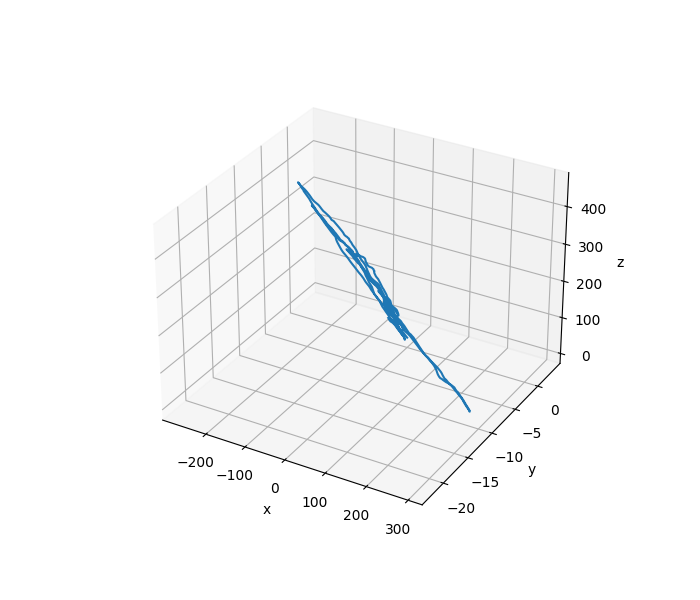

Text(0.5, 0, 'z')

In [8]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

We can see that the trajectory starts and ends in the same spot, working around some corners, slanted on a bit of a hill.

Now let's take a quick look at our first image.

In [9]:
test_img = cv2.imread('../dataset/sequences/00/image_0/000000.png')

In [10]:
type(test_img)

numpy.ndarray

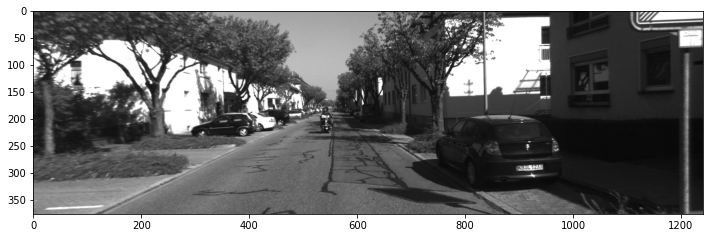

In [11]:
%matplotlib inline
plt.figure(figsize=(12,6))
plt.imshow(test_img)

## Data Exploration

In [12]:
# We can use the listdir() function to get a list of filenames in a folder
left_image_files = os.listdir('../dataset/sequences/00/image_0')
left_image_files[:5]

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

In [13]:
# We can use this list to count the number of images in the sequence
len(left_image_files)

4541

In [14]:
# Now we can check if this matches the number of ground truth posesa
len(poses)

4541

In [15]:
# We can see they match perfectly. Our first ground truth pose is (0, 0, 0), so we
# are tracking the motion of the camera with respect to the first camera frame.

In [16]:
times = pd.read_csv('../dataset/sequences/00/times.txt', delimiter=' ', header=None)
times.head()

0
0  0.000000
1  0.103736
2  0.207338
3  0.311075
4  0.414692

In [17]:
# We can see that the timing of the camera is right around 10fps

### Projection Matrices - Sensor Calibration

In [18]:
# We can load in our sensor calibration data as follows
calib = pd.read_csv('../dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

1         2           3           4         5           6   \
0                                                                         
P0:  718.856000  0.000000  607.192800    0.000000  0.000000  718.856000   
P1:  718.856000  0.000000  607.192800 -386.144800  0.000000  718.856000   
P2:  718.856000  0.000000  607.192800   45.382250  0.000000  718.856000   
P3:  718.856000  0.000000  607.192800 -337.287700  0.000000  718.856000   
Tr:    0.000428 -0.999967   -0.008084   -0.011985 -0.007211    0.008081   

             7         8         9         10        11        12  
0                                                                  
P0:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P1:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P2:  185.215700 -0.113089  0.000000  0.000000  1.000000  0.003780  
P3:  185.215700  2.369057  0.000000  0.000000  1.000000  0.004915  
Tr:   -0.999941 -0.054040  0.999974  0.000486 -0.007207 -0.292197

We can see that they have provided us 3x4 projection matrices for 4 cameras, as well as the transformation matrix for the LIDAR labeled Tr. It is important to note that in the readme file for the dataset, these are the camera rectification matrices AFTER RECTIFICATION, which means that they are not normal rectification matrices. I will go into this more in just a moment.

*IMPORTANT NOTE*: If you DO NOT see a 5th row in the dataframe above labeled 'Tr', then, like me, your download did not come with a proper calibration file. This can be resolved by downloading the calibration file from [this link](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip) and replacing the files in your dataset (use WinRAR to extract to the directory of your dataset and it will automatically merge the files into their correct locations). We won't be using LIDAR in this tutorial, so you can ignore this and keep following along, but you should have the right files for your own sake, and future tutorials will involve the LIDAR data.

In [19]:
# P0 is the projection matrix left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

On the subject of projection matrices, let's take a moment to discuss what information is contained in these 3x4 matrices, and how it is useful to us. These matrices contain intrinsic information about the camera's focal length and optical center, which we will discuss later. Further, they also contain tranformation information which relates each camera's coordinate frame to the global coordinate frame (in this case that of the left grayscale camera).

A projection matrix takes 3D coordinates in the global coordinate frame and projects them onto the image plane of the camera through the formula:

![Projection Matrix](images/projection_matrix.png)

Notice that the left side of the equation is being multiplied by λ to be equivalent to the right side of the equation. This is known as the scale, and this is the depth to the point along the Z axis from the camera, that is, the Z value AFTER the transformation R|t has been applied to the 3D point to bring it into the camera's coordinate frame. Since we really want the homogeneous pixel coordinates (u, v, 1) that project the 3D point (X, Y, Z, 1), this equation may be more clearly written as:

![Projection Matrix 2](images/projection_matrix2.png)

We will return to talking about lambda (λ) in a moment. Let us first break down the relationship between a camera's projective matrix and its intrinsic and extrinsic matrices.

A projection matrix (P) is the dot product of the intrinsic and extrinsic matrices of a camera. The intrinsic matrix (k) contains the focal length and optical center parameters, and the extrinsic matrix (R|t) contains the pose of the camera in the same form we saw earlier with the ground truth poses of the car: a 3x3 rotation matrix horizontally stacked with a 3x1 translation vector. We can see the formula for P below:

![Projection Matrix Equation](images/P_matrix_eq.png)

Breaking down the P matrix into intrinsic and extrinsic camera matrices in the above equation then provides us with the following, which is a more explicit description of the process of projecting a 3D point in any coordinate frame into the pixel coordinate frame of the camera:

![Broken into Intrinsic and Extrinsic](images/intrinsic_extrinsic.png)

Now, remember that the projection matrices from the caibration file are the camera projection matrices for each camera AFTER RECTIFICATION in terms of the stereo rig. Normally, a camera's projection matrix take a 3D point in a global coordinate frame and projects it onto pixel coordinates on THAT camera's image frame. Rectified projection matrices are the opposite, and are designed to map points each camera's coordinate frame onto one single image plane: that of the left camera. This means they are going in the opposite direction, as these matrices are taking 3D points from the coordinate frame of the camera they are associated with, and projecting them onto the image plane of the left camera. If phrased in terms of normal projection matrix logic, P0 through P1 are basically 4 different projection matrices for the same (left grayscale) camera, considering 4 different "global" coordinate frames for each one of the cameras.

We can make a concrete example of the difference by considering the schematic of the sensor configuration provided by the KITTI team:

![KITTI Schematic](images/kitti_schematic.png)

We can see from the schematic that there are two stereo pairs of cameras, one set of grayscale and one set of RGB, and that the baseline (distance between right and left) is 0.54 meters on the X axis of the left grayscale camera.

If the projection matrices provided were standard per-camera projection matrices, we would expect the extrinsic matrix to take a point from the global coordinate frame and tranform it into the frame of the camera. For example, if we were to take the origin of the global coordinate frame (the origin of the left grayscale camera) and translate it into the coordinate frame of the right grayscale camera, we would expect to see an X coordinate of -0.54, since the left camera's origin is 0.54 meters to the left of the right grayscale camera's origin. To test this, we can decompose the projection matrix given for the right camera into k, R, and t though a useful function in OpenCV:

In [20]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print(k1)
print(r1)
print(t1.round(4))

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [21]:
# Above, we can see the intrinsic matrix k, the rotation matrix R, and the translation vector
# t we got by decomposing the projection matrix given for the right camera. Remember that
# the extrinsic matrix is actually a horizontal stack of R and t in the form (R|t), which
# we can use to transform a 3D homogenous coordinate in the global frame to a 3D coordinate
# in the camera frame, at least if this were a normal camera projection matrix.
# In this case, let's see what we get if we transform the origin of the global coordinate
# frame (the origin of the left grayscale camera) using the tranformation/extrinsic matrix
# we got from this projection matrix. According to the schematic, we should expect it to be
# 0.54m to the left (X = -0.54)
# Note that the OpenCV function has provided t as a homogeneous coordinate, so we need to
# drop the fourth value to horizontally stack it with the 3x3 rotation matrix.
Rt = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
origin = np.array([0, 0, 0, 1])
Rt.dot(origin).round(4).reshape(-1,1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [22]:
# And here we can see the issue: the X value is POSITIVE 0.54, which points 0.54m to the right
# of the camera frame, which tells us that this projection matrix is NOT actually referring to
# the right camera, it is referring to the left camera, and treating the origin of the right
# camera as the global coordinate frame. This is because it is a rectified projection matrix
# for a stereo rig, which is intended to project points from the coordinate frames of multiple
# cameras onto the SAME image plane, rather than the coordinates from one coordinate frame onto
# the image planes of multiple cameras.

Each rectified projection matrix will take (X, Y, Z, 1) homogeneous coordinates of 3D points in the associated sensor's coordinate frame and translates them to pixel locations (u, v, 1) on the image plane of the left grayscale camera.

Notice that the result we got from translating the origin is identical to the translation vector itself, so it is not necessary to do the extra step of math to figure out where the origin of the "global" coordinate frame is in relation to a camera, one only has to look at t. In this case, we can see that the rectified projection matrix decomposes into an extrinsic matrix which tells us that the "global" coordinate frame origin of the right camera is 0.54m to the right of the left camera, which matches what we see in the schematic.

In [23]:
# As an exercise, let's turn this rectified projection matrix into a regular projection matrix
# for the right grayscale camera. We do this by decomposing the matrix, making the extrinsic
# matrix homogeneous, inverting it, then recombining the intrinsic and inverted extrinsic.
# Since we've already decomposed and stacked the Rt transformation matrix, let's now make
# it homogeneous and run our test to see if the origin of the left camera appears at X=-0.54
T_homogeneous = np.vstack([Rt, np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
print(T_homogeneous.round(4))
print(T_hom_inv.round(4))

[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


In [24]:
# We can see that our t vector has indeed moved to -0.54
# If we want to have normal P matrices for each camera, this is the process we would follow
# This would come in handy if we were going to do visual odometry in the left and right 
# cameras simultaneously to smooth out noise. For now, we're just going to stick to one.

Now that we know what these calibration matrices are actually telling us, and that they are in all in reference to the left grayscale camera's image plane, let's go back and look again at the equation which projects 3D points form a given coordinate frame onto the image plane of a camera, and talk more about the lambda (λ) value. λ will have a single value when considering a single point transformation, or be a vector containing a separate value for each point if using the equation for matrices of multiple 3D points. Its value is equal to the Z value obtained AFTER the tranformation (R|t) has been applied to the 3D point, so the Z value of the point in the coordinate frame of the camera. This is the depth of the point from the camera. Because we are projecting 3D points onto a 2D surface, by dividing each point by its depth, we are projecting all of them onto a plane which is 1 unit away from the origin of the camera down the Z axis, since all points will subsequently have a Z value of 1 after the division. 

Note that the division by lambda in the right side of the equation can happen AT ANY POINT in the order of operations, that is, you could directly divide (X, Y, Z, 1) by it, then do the dot products, or divide the dot product of R|t and (X, Y, Z, 1) by it, then do the dot product with k, or do all the dot products and divide the result by it, and the result will be the same. Of course, the first option just listed doesn't make much sense, since we obtain the value of λ taking the dot product of R|t and (X, Y, Z, 1) and extracting the resulting Z coordinate in the camera frame, but nonetheless, we will do each computation now in python to prove the point.

In [25]:
# Let's take some point measured with respect to the coordinate frame of the left camera when 
# it is in it's 14 pose of the sequence, and transform it onto the image plane of the camera
# in it's first position, which we can do by using accessing the 14th pose from the ground truth
# Here are the coordinates of the point measured in this frame
some_point = np.array([1, 2, 3, 1]).reshape(-1,1)
# Let's get the depth of this point from the left camera by tranforming it into the coordinate
# frame of the left camera, and taking the Z value. We can do the transformation using the
# Rt matrix we stacked a moment ago.
transformed_point = gt[14].dot(some_point)
depth_from_cam = transformed_point[2]

print('Original point:\n', some_point)
print('Transformed point:\n', transformed_point.round(4))
print('Depth from camera:\n', depth_from_cam.round(4))

Original point:
 [[1]
 [2]
 [3]
 [1]]
Transformed point:
 [[ 0.2706]
 [ 1.5461]
 [15.0755]]
Depth from camera:
 [15.0755]


In [26]:
# To project this 3D point onto the image plane, we could first apply the intrinsic matrix, 
# THEN divide by the depth, which would take us from meters, to pixel*meters, then to pixels,
# or we could just divide by the depth first, taking us into unitless measurements by dividing
# meters by meters,then multiply by the intrinsic matrix, which would then take us from 
# unitless to pixels

# Multiplying by intrinsic matrix k, then dividing by depth
pixel_coordinates1 = k1.dot(transformed_point) / depth_from_cam

# Dividing by depth then multiplying by intrinsic matrix k
pixel_coordinates2 = k1.dot(transformed_point / depth_from_cam)

print('Pixel Coordinates 1st way:', pixel_coordinates1.T)
print('Pixel Coordinates 2nd way:', pixel_coordinates2.T)

Pixel Coordinates 1st way: [[620.09802465 258.93763336   1.        ]]
Pixel Coordinates 2nd way: [[620.09802465 258.93763336   1.        ]]


In [27]:
# We can see that we get the same results either way.
# Another thing that is done regularly is "normalizing" the pixel coordinates by multiplying
# them by the inverse of the intrinsic matrix k, which brings us back into unitless values,
# as we take pixel measurements and multiply them by the inverse of pixel measurements.
normalized_coordinates = np.linalg.inv(k1).dot(pixel_coordinates1)
print('Normalized Coordinates:', normalized_coordinates.T)

Normalized Coordinates: [[0.01795245 0.10255452 1.        ]]


In [28]:
# This is often done when using a series of points to estimate camera matrices, which we will
# not be doing, but it is important to know the reason why. Since the homogeneous pixel
# coordinates have large values representing the pixel positions, and have a small third
# componenet of 1, they can produce ill-conditioned matrices when using them to solve complex
# mathematical operations, so the normalized coordinates are used in these scenarios instead.
# For our purposes, it is interesting to see that if we take the normalized coordinates and
# multiply them by their respective depths, we can reconstruct the original 3D position from
# the 2D projection of a point (as long as we know the depth)
restored_3D = normalized_coordinates.T * depth_from_cam
restored_3D.round(4)

array([[ 0.2706,  1.5461, 15.0755]])

In [29]:
# And we are back to 3D coordinates in our camera frame.
# To get back to the 3D position in our original coordinate frame, we can add a row of
# (0, 0, 0, 1) to the transformation matrix we used to make it homogeneous, then invert it, 
# and finally dot it with the restored 3D coordinates in the camera frame (note that we
# also need to add a 1 to the end of these coordinates to make them homogeneous as well)
T_homogeneous = np.vstack([gt[14], np.array([0, 0, 0, 1])])
T_hom_inv = np.linalg.inv(T_homogeneous)
restored_3D_hom = np.append(restored_3D, 1)
T_hom_inv.dot(restored_3D_hom)

array([1., 2., 3., 1.])

In [30]:
# And there we have it, we went from a 3D point on a coordinate frame, projected it to pixel
# coordinates of a camera in a separate coordinate frame, reconstructed the metrics using a 
# known depth, and then reverse transformed the 3D point back into the original frame by
# inverting a homogeneous version of the original transformation matrix used and dotting it with
# the homogeneous 3D coordinates of the point in the camera's coordinate frame. This type of 
# math will come in handy later when we want to figure out where the car is in reference to the
# global coordinate frame.

What if we want to find the pixel coordinates of a 3D point located in the same frame as the camera? Recall that the first ground truth pose was an extrinsic matrix which was composed of an identity rotation matrix and a translation vector (0,0,0). Since an extrinsic matrix relates the pose of the camera to the global coordinate frame where (X, Y, Z, 1) are measured, and the first camera position IS the global coordinate frame, there is no transformation (rotation and tranlation) between them. Considering this alongside the above equations, we can see that if (X, Y, Z, 1) is measured in the camera's own coordinate frame, then the equation above becomes:

![Coordinate-to-Pixel](images/coordinate2pixel.png)

Recall that λ is the value of Z after 3D coordinates have been transformed, and since that has already happened here, we can rewrite the equation as follows to get to pixel coordinates:

![XYZ to Pixels](images/xyz2pixels.png)

Or we may wish to be in normalized (x, y, 1) coordinates by either not multiplying by k, or by dotting the inverse of k with (u, v, 1):

![XYZ to normalized](images/to_normalized.png)

Where (x_tilde, y_tilde, 1) are the normalized coordinates we discussed earlier, which represent the 3D points projected onto a 2D plane which is 1 unit (unitless) away from the origin of the camera down the Z axis. Let's take another look at the image we saw earlier to get an intuition for what this looks like.

![Camera Frame](images/camera_frame.png)

We can see that this picture depicts the image plane (x, y) and the pixel coordinate frame (u, v) together. Astute readers my see a difference from our concept of normalized coordinates here, however: the image plane is defined here as Z = f, meaning that the image plane is f (in meters) away from the camera origin. This is actually what you expect, since this is exactly what the focal length tells us about a pinhole camera: how far away from the aperture do the light rays converge to create a clear image. We can look at this old drawing of the first concept of a camera, the camera obscura, to get a very simple intuition for this:

![Camera Obscura](images/camera_obscura.jpg)

In this picture, the focal length is the distance between the wall with the hole and the wall with the image appearing. In modern camera modeling, we just flip this upside down image back around the origin back onto the positive Z axis, but it would still be on the plane Z = f. So how did we get to talking about a plane at Z = 1? For one thing, when we were talking about our normalized (x, y, 1) coordinates, we were unitless, so you might see where this is going: we've divided by the focal length in meters along the way. But where? I honestly had to do a lot of digging to figure this part out, but I'll explain it now.

First, let's look at a slide from Rober Collins of Penn State, and see that the coordinates on our image plane are derived using similar triangles and the focal length of the camera:

![Collins Similar Triangles](images/similar_triangles.png)

We can see that this projects the 3D coordinates onto a 2D surface which is the distance f (focal distance) from the origin of the camera, just like we expect when looking at the picture of the old timer above, where the image on the wall is f meters from the hole in the opposite wall. More concisely, we can write this projection like this:

![2D Projection](images/2d_projection.png)

We can see here that since the focal length f is in meters, and Z is in meters, the vector (X, Y, Z) (which is in meters) is being multiplied by a unitless ratio between focal distance and depth to point, so it maintains the unit of meters in the vector (x, y, f). This makes sense, since if the old timer above were to measure (x, y) coordinates of the image on the wall, he would be doing so in meters, and those measurements would be f meters from the pinhole, so they would all be at (x, y, f).

The secret is that the formula to calculate the 2D projection in pixel coordinates from a 3D coordinate in the same coordinate frame as the camera is actually as follows:

![True Formula](images/true_formula.png)

Where we can see that we cancel out the focal length multiplication with the projection on the right side. How is it that we're getting away with multiplying only one side by 1/f? The answer is that the intrinsic matrix actually contains f, but measured in pixels. The contents of the intrinsic matrix are as follows:

![Intrinsic Matrix](images/intrinsic_matrix.png)

So we see then that we are still multiplying x and y by f, but not z. Why not? It seems there are two reasons: 1) Nobody cares how far a point in a 2D image is in pixels away from the origin of the camera, the information is not useful; and 2) By keeping the third value of (u, v, 1) a 1, we have a happy set of 2D homogeneous coordinates which make math easier. The short answer is, we simply threw away the information about the depth to the image plane because it tells us nothing about anything. Once we divided by λ, we lost all useful depth information about our 3D point(s), and this cannot be retrieved without finding it some other way. This is where the stereo rig steps in!

The remaining two values in the intrinsic matrix, c_x and c_y, represent the optical center of the image, that is, where rays of light coming directly down the Z axis of the camera coordinate frame will intersect the pixel plane. While one might want to assume that this would be at the center of the camera's sensor, it is often the case that the sensor is slightly off of center with the lens, so this adjustment in the intrinsic matrix ensures that we are mapping incoming light rays to the proper pixel coordinate they will be at when they hit the camera sensor.

In [31]:
# Let's compare the optical center to the size of the image (expect it to be halfway?)
test_img.shape

(376, 1241, 3)

In [32]:
cx = k1[0,2]
cy = k1[1,2]
print('Actual center of image (x, y):', (test_img.shape[1]/2, test_img.shape[0]/2))
print('Optical center of image (cx, cy)', (cx, cy))

Actual center of image (x, y): (620.5, 188.0)
Optical center of image (cx, cy) (607.1928, 185.2157)


In [33]:
# We can see that the optical center of the camera is very close, but not quite, the center of
# the image itself. This is why camera calibration information is important, because if we had
# assumed that light coming down the camera's Z axis hit the center of the image plane, we would
# have been projecting points in the world to the wrong parts of the image.

Let's just take a quick moment to look at the other two camera matrices included in our calibration file, which refer to the RGB cameras in the rig.

In [34]:
# The next two matrices are referring to the RGB cameras. In that case we won't
# need them, but let's see if this makes sense
P2 = np.array(calib.loc['P2:']).reshape((3,4))
k2, r2, t2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
t2 = t2 / t2[3]
print(k2)
print(r2)
print(t2)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.05993858]
 [ 0.00113119]
 [-0.00377976]
 [ 1.        ]]


In [35]:
# We can see that this camera is just slightly to the left of the main camera.
# Let's now repeat this process for the fourth P matrix and see what we see
P3 = np.array(calib.loc['P3:']).reshape((3,4))
k3, r3, t3, _, _, _, _ = cv2.decomposeProjectionMatrix(P3)
t3 = t3 / t3[3]
print(k3)
print(r3)
print(t3)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 0.47335236]
 [-0.00202917]
 [-0.00491521]
 [ 1.        ]]


Hopefully I have not lost you with all of this theoretical review, but it really helps to have a full intuitive understanding of these concepts as we move forward with out stereo depth estimation and visual odometry project here.

### Dataset Handling
Let's make a dataset handling object to make our data more accessible as we complete our task.

In [74]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True, progress_bar=True):
        import pandas as pd
        import os
        import cv2
        
        seq_dir = '../dataset/sequences/{}/'.format(sequence)
        poses_dir = '../dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        left_image_files = os.listdir(seq_dir + 'image_0')
        right_image_files = os.listdir(seq_dir + 'image_1')
        velodyne_files = os.listdir(seq_dir + 'velodyne')
        self.num_frames = len(left_image_files)
        
        # Get calibration details for scene
        # P0 and P1 are Grayscale cams, P2 and P3 are RGB cams
        calib = pd.read_csv(seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        # This is the transformation matrix for LIDAR
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(seq_dir + 'times.txt', delimiter=' ', header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        if progress_bar:
            import progressbar
            bar = progressbar.ProgressBar(max_value=self.num_frames)
        self.images_left = []
        self.images_right = []
        self.pointclouds = []
        for i, name_left in enumerate(left_image_files):
            name_right = right_image_files[i]
            self.images_left.append(cv2.imread(seq_dir + 'image_0/' + name_left))
            self.images_right.append(cv2.imread(seq_dir + 'image_1/' + name_right))
            if lidar:
                lidar_path = seq_dir + 'velodyne/' + velodyne_files[i]
                pointcloud = np.fromfile(lidar_path, dtype=np.float32, count=-1).reshape([-1,4])
                self.pointclouds.append(pointcloud)
            if progressbar:
                bar.update(i+1)
            #print ("Data loading: {0}%".format(int((i + self.num_frames) / (self.num_frames * 2 - 1) * 100)), end="\r")
        self.imheight = self.images_left[0].shape[0]
        self.imwidth = self.images_left[0].shape[1]

In [37]:
handler = Dataset_Handler('00')

100% (4541 of 4541) |####################| Elapsed Time: 0:01:51 ETA:  00:00:00

# Stereo Depth + Visual Odometry (No LIDAR)
In this section, I will attempt to track the pose of the vehicle using depth maps derived from stereopsis, then using visual odometry of the left camera to track motion at scale.

In [38]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, cuda=True,
                               verbose=False):
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    
    if matcher == 'bm':
        if cuda:
            matcher = cv2.cuda_StereoBM()
            matcher = matcher.create(numDisparities=num_disparities,
                                        blockSize=block_size)
        else:
            matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                          blockSize=block_size)
        
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        rgb = False
        
    elif matcher == 'sgbm':
        if cuda:
            matcher = cv2.cuda_StereoSGM()
            matcher = matcher.create(numDisparities=num_disparities,
                                    minDisparity=0,
                                    blockSize=block_size,
                                    P1 = 8 * 3 * sad_window ** 2,
                                    P2 = 32 * 3 * sad_window ** 2,
                                    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                   )
        else:
            matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                            minDisparity=0,
                                            blockSize=block_size,
                                            P1 = 8 * 3 * sad_window ** 2,
                                            P2 = 32 * 3 * sad_window ** 2,
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                           )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print('Time to compute disparity map:', end-start)
    
    return disp_left

In [39]:
%matplotlib inline

Time to compute disparity map: 0:00:00.113009


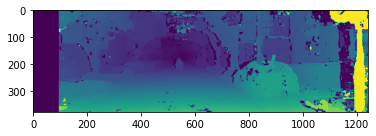

In [85]:
disp = compute_left_disparity_map(handler.images_left[0], 
                                  handler.images_right[0], 
                                  matcher='sgbm',
                                  verbose=True)
plt.imshow(disp)

We can see that there is a gap of the left side of the image where the right camera did not have information. This means that we should apply a mask when looking for features to match from one frame to the next so that we can use features which fall in the area of the picture for which we have depth information.

In [86]:
disp[0,0]

-1.0

In [87]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t / t[3]
    
    return k, r, t

def calc_depth_map(disp_left, k_left, t_left, t_right):
    f = k_left[0][0]
    t_left = t_left[:3]
    t_right = t_right[:3]
    b = t_right[0] - t_left[0] 
    disp_left[disp_left == 0] = 0.1
    disp_left[disp_left == -1] = 0.1
    depth_map = np.ones(disp_left.shape, np.single)
    depth_map = f * b / disp_left
    
    return depth_map

In [88]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

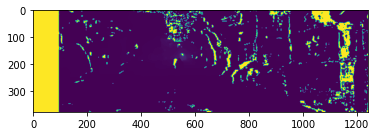

In [89]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.imshow(depth)

In [90]:
depth[0,1]

3861.447942459941

In [91]:
depth.max()

3861.447942459941

In [92]:
for i, pixel in enumerate(depth[4]):
    if pixel < depth.max():
        print('First non-max value at index', i)
        break

First non-max value at index 96


In [93]:
%matplotlib inline

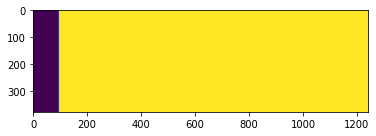

In [94]:
mask = np.zeros(handler.images_left[0].shape[:2], dtype=np.uint8)
ymax = handler.images_left[0].shape[0]
xmax = handler.images_left[0].shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask)

In [95]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False):
    disp = compute_left_disparity_map(img_left, img_right, matcher, rgb, verbose)
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    return depth

In [117]:
def extract_features(image, detector='sift', mask=None, cuda=True):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        if cuda:
            det = cv2.cuda.ORB_create()
            src = cv2.cuda_GpuMat()
            src.upload(image)
            dst = det.detectAndCompute(src, cv2.cuda_Stream.Null())
            kp, des = dst.download()
        else:
            det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
    
    if detector != 'orb':
        kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [110]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [111]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [112]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 3206
Number of matches after filtering: 446


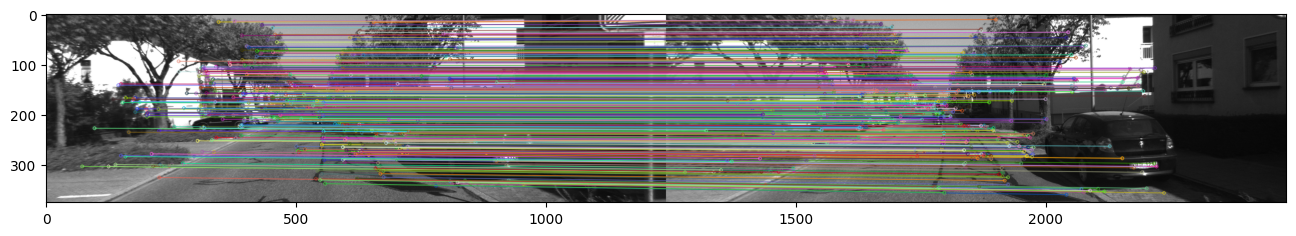

In [113]:
# Look at matched points using sgbm matcher
image_left = handler.images_left[0]
image_right = handler.images_right[0]
image_plus1 = handler.images_left[1]
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Number of matches before filtering: 3206
Number of matches after filtering: 446


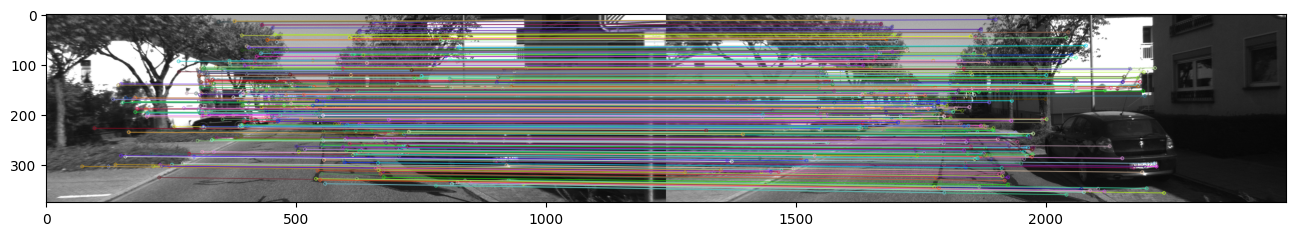

In [114]:
# Now to see the difference with 'bm' matcher
image_left = handler.images_left[0]
image_right = handler.images_right[0]
image_plus1 = handler.images_left[1]
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [115]:
# We can see that the 'bm' matcher is around 5x faster than the 'sgbm' matcher, and produced the
# same number of matches. Since speed is essential, we will use the 'bm' matcher

In [118]:
# Now to see the difference with ORB descriptor
image_left = handler.images_left[0]
image_right = handler.images_right[0]
image_plus1 = handler.images_left[1]
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'orb')
kp1, des1 = extract_features(image_plus1, 'orb')
matches = match_features(des0, des1, matching='BF', detector='orb', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.8)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

TypeError: Expected Ptr<cv::UMat> for argument 'image'

In [68]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    # We know the lidar x axis points forward, we need nothing behind the lidar
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    # Transfer point cloud into left camera frame
    projection_xyz = handler.Tr.dot(pointcloud.T)
    # Ignore any points behind the camera
    projection_xyz = projection_xyz[:, projection_xyz[2] > 0]
    # Euclidean distance depth measure
    #depth = np.sqrt(projection_xyz[0] **2 + projection_xyz[1]**2 + projection_xyz[2]**2)
    # Z depth measure
    depth = projection_xyz[2]
    projection_xyz = np.vstack([projection_xyz, np.ones(projection_xyz.shape[1])])
    projection = handler.P0.dot(projection_xyz)
    projection = (projection / projection[2])
    # Turn pixels into integers
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    pixel_coordinates = np.array(pixel_coordinates)
    # Limit pixel coordinates considered to those that fit on the image plane
    pixel_coordinates = pixel_coordinates[pixel_coordinates[:, 0] < imwidth]
    pixel_coordinates = pixel_coordinates[pixel_coordinates[:, 0] >= 0]
    pixel_coordinates = pixel_coordinates[pixel_coordinates[:, 1] < imheight]
    pixel_coordinates = pixel_coordinates[pixel_coordinates[:, 1] >= 0]
    # Establish empty render image, then fill with the depths of each point
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
    # Fill zero values with large distance so they will be ignored
    render[render == 0.0] = 3861.45
    
    return render

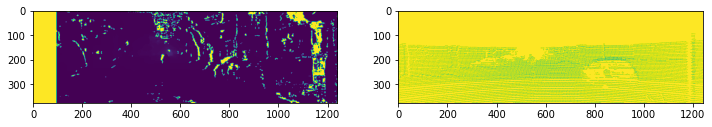

In [69]:
depth_stereo = stereo_2_depth(image_left, 
                             image_right, 
                             handler.P0, 
                             handler.P1,
                             matcher='sgbm',
                             verbose=True)
depth_lidar = pointcloud2image(handler.pointclouds[0], handler.imheight, handler.imwidth,
                               handler.Tr, handler.P0
                              )
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(depth_stereo)
ax2.imshow(depth_lidar)

In [70]:
idx_height, idx_width = np.where(depth_lidar < 3000)
depth_indx = np.array(list(zip(idx_height, idx_width)))
#intpts = np.round(image1_points,0).astype('int')
#idx = np.where((intpts[:,None] == np.array(depth_indx)).all(2).any(1))
#image1_points = image1_points[intidx]
#image2_points = image2_points[intidx]
comparison = np.hstack([depth_stereo[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1), 
                        depth_lidar[depth_indx[:, 0], depth_indx[:, 1]].reshape(-1,1)
                       ])
for i, row in enumerate(comparison):
    print('location:', depth_indx[i], 'stereo/lidar depth:', row)
    if i > 100:
        break

location: [  95 1200] stereo/lidar depth: [ 4.06468211 14.50763832]
location: [  96 1194] stereo/lidar depth: [24.61480797 14.59496173]
location: [  96 1198] stereo/lidar depth: [17.06717348 14.58731414]
location: [  96 1204] stereo/lidar depth: [ 4.06468211 14.53782356]
location: [  96 1208] stereo/lidar depth: [ 4.06468211 15.50945642]
location: [ 102 1195] stereo/lidar depth: [24.42022451  4.55530487]
location: [ 102 1199] stereo/lidar depth: [4.06468211 4.53652272]
location: [ 102 1203] stereo/lidar depth: [4.06468211 4.50194617]
location: [ 102 1206] stereo/lidar depth: [4.06468211 4.46737825]
location: [ 106 1203] stereo/lidar depth: [ 4.06468211 42.18420183]
location: [ 106 1206] stereo/lidar depth: [ 4.06468211 56.23245761]
location: [ 107 1195] stereo/lidar depth: [11.61337744 54.71866978]
location: [ 107 1199] stereo/lidar depth: [11.56988165 42.14588032]
location: [ 113 1204] stereo/lidar depth: [4.06468211 1.23748929]
location: [ 113 1206] stereo/lidar depth: [4.06468211 1.

In [127]:
from jupyterthemes import jtplot
jtplot.style()

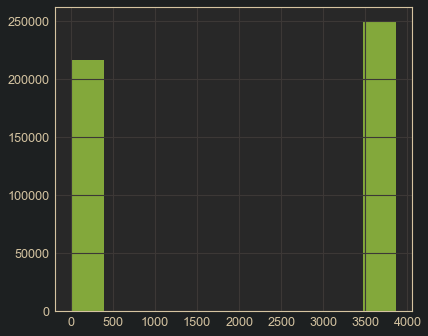

In [128]:
# Let's see the distribution of depths from our depth map, so we can decide a threshold to cut
# off points of consideration so they don't mess with our geometry
plt.hist(depth.flatten());

In [129]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix 
    
    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are 
                     coordinates of the i-th match in the image coordinate system
               
    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        #idx_height, idx_width = np.where(depth1 < 3000)
        #depth_indx = np.array(list(zip(idx_width, idx_height)))
        #intpts = np.round(image1_points,0).astype('int')
        #intidx = np.where((intpts[:,None] == np.array(depth_indx)).all(2).any(1))
        #image1_points = image1_points[intidx]
        #image2_points = image2_points[intidx]
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            if z > 3000:
                delete.append(i)
                continue
            #else:
            #    print(u,v)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
            #object_points[i, :] = np.linalg.inv(k).dot(z*np.array([u, v, 1]))
            # Equivalent math with dot product w/ inverse of k matrix, but SLOWER (see Appendix)
            #object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u, v, 1]))])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)

        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [130]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', depth_type='stereo', mask=None, lidar=False, 
                    icp_thresh=0.02, subset=None):
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Using ICP of LIDAR point clouds to improve visual odometry')
    #Tmats = []
    if subset is not None:
        subset = subset + 1
    T_tot = np.eye(4)
    num_frames = len(handler.images_left[:subset])
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.images_left[0].shape[0]
    imwidth = handler.images_left[0].shape[1]
    
    # Iterate through all frames of the sequence
    for i, image_left in enumerate(handler.images_left[:subset]):
        if i == num_frames - 1:
            break
        start = datetime.datetime.now()
        image_right = handler.images_right[i]
        image_plus1 = handler.images_left[i+1]
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   handler.P0, 
                                   handler.P1,
                                   matcher=stereo_matcher)
        elif depth_type == 'lidar':
            pointcloud = handler.pointclouds[i]
            # Use function to project pointcloud to image plane
            depth = pointcloud2image(pointcloud, imheight, imwidth, handler.Tr, handler.P0)
            #plt.imshow(depth)
            #plt.show()
            
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        matches_unfilt = match_features(des0, des1, matching=matching, detector=detector, sort=True)
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
        
        # Try to get motion with filter distance, if not increase threshold until success
        try:
            rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
        except:
            filt_inc = 0.1
            while True:
                try:
                    matches = filter_matches_distance(matches_unfilt, filter_match_distance+filt_inc)
                    rmat, tvec, img1_points, img2_points = estimate_motion(matches, 
                                                                           kp0, 
                                                                           kp1, 
                                                                           k_left, 
                                                                           depth)
                    break
                except:
                    filt_inc += 0.1
                    continue
                    
        Tmat = np.zeros((4, 4))
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        Tmat[3, 3] = 1
        #Tmats.append(Tmat)
        if lidar:
            src = o3d.geometry.PointCloud()
            dst = o3d.geometry.PointCloud()
            src.points = o3d.utility.Vector3dVector(handler.pointclouds[i][:, :3])
            dst.points = o3d.utility.Vector3dVector(handler.pointclouds[i+1][:, :3])
            reg_p2p = o3d.pipelines.registration.registration_icp(src, 
                                                                  dst, 
                                                                  icp_thresh, 
                                                                  Tmat,
                                o3d.pipelines.registration.TransformationEstimationPointToPoint())
            Tmat = reg_p2p.transformation
        
        current_pos = np.array([0, 0, 0, 1])
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
        #T_tot = np.eye(4)
        #for j in range(len(Tmats)):
        #    T_tot = T_tot.dot(np.linalg.inv(Tmats[j]))
            
        trajectory[i+1, :, :] = T_tot[:3, :]
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
    return trajectory

In [82]:
start = datetime.datetime.now()
trajectory = visual_odometry(handler,
                             filter_match_distance=0.5, 
                             detector='sift',
                             #matching='FLANN',
                             mask=mask,
                             lidar=False,      
                             subset=100)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.493002
Time to compute frame 2: 0:00:00.512997
Time to compute frame 3: 0:00:00.505006
Time to compute frame 4: 0:00:00.524998
Time to compute frame 5: 0:00:00.540000
Time to compute frame 6: 0:00:00.537000
Time to compute frame 7: 0:00:00.532996
Time to compute frame 8: 0:00:00.519006
Time to compute frame 9: 0:00:00.504999
Time to compute frame 10: 0:00:00.526999
Time to compute frame 11: 0:00:00.488993
Time to compute frame 12: 0:00:00.532998
Time to compute frame 13: 0:00:00.474997
Time to compute frame 14: 0:00:00.468000
Time to compute frame 15: 0:00:00.452995
Time to compute frame 16: 0:00:00.437000
Time to compute frame 17: 0:00:00.466997
Time to compute frame 18: 0:00:00.464001
Time to compute frame 19: 0:00:00.477997
Time to compute frame 20: 0:00:00.479001
Time to compute frame 21: 0:00:00.503995
Time t

In [468]:
start = datetime.datetime.now()
trajectory = visual_odometry(handler,
                             filter_match_distance=0.5, 
                             detector='sift',
                             #matching='FLANN',
                             mask=mask,
                             lidar=True,      
                             subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Using ICP of LIDAR point clouds to improve visual odometry
Time to compute frame 1: 0:00:02.555672
Time to compute frame 2: 0:00:02.753087
Time to compute frame 3: 0:00:02.006540
Time to compute frame 4: 0:00:02.704408
Time to compute frame 5: 0:00:02.582949
Time to compute frame 6: 0:00:02.691597
Time to compute frame 7: 0:00:03.157184
Time to compute frame 8: 0:00:02.254188
Time to compute frame 9: 0:00:03.124867
Time to compute frame 10: 0:00:02.917566
Time to compute frame 11: 0:00:02.522343
Time to compute frame 12: 0:00:03.064673
Time to compute frame 13: 0:00:02.952914
Time to compute frame 14: 0:00:02.117577
Time to compute frame 15: 0:00:02.386741
Time to compute frame 16: 0:00:02.167594
Time to compute frame 17: 0:00:02.732074
Time to compute frame 18: 0:00:02.550266
Time to compute frame 19: 0:00:02.197062
Time to compute frame 20: 0:0

Time to compute frame 194: 0:00:03.326445
Time to compute frame 195: 0:00:02.278944
Time to compute frame 196: 0:00:02.380850
Time to compute frame 197: 0:00:03.023567
Time to compute frame 198: 0:00:03.390804
Time to compute frame 199: 0:00:03.259617
Time to compute frame 200: 0:00:03.654827
Time to compute frame 201: 0:00:03.361074
Time to compute frame 202: 0:00:02.192983
Time to compute frame 203: 0:00:02.460834
Time to compute frame 204: 0:00:02.521896
Time to compute frame 205: 0:00:03.000831
Time to compute frame 206: 0:00:02.712845
Time to compute frame 207: 0:00:02.199137
Time to compute frame 208: 0:00:01.880801
Time to compute frame 209: 0:00:03.028910
Time to compute frame 210: 0:00:02.884043
Time to compute frame 211: 0:00:02.844452
Time to compute frame 212: 0:00:02.761910
Time to compute frame 213: 0:00:03.324309
Time to compute frame 214: 0:00:02.422443
Time to compute frame 215: 0:00:02.841471
Time to compute frame 216: 0:00:02.647561
Time to compute frame 217: 0:00:03

Time to compute frame 390: 0:00:02.797493
Time to compute frame 391: 0:00:02.915749
Time to compute frame 392: 0:00:02.677694
Time to compute frame 393: 0:00:02.872003
Time to compute frame 394: 0:00:02.876944
Time to compute frame 395: 0:00:03.106805
Time to compute frame 396: 0:00:02.903102
Time to compute frame 397: 0:00:02.875634
Time to compute frame 398: 0:00:01.980772
Time to compute frame 399: 0:00:02.725501
Time to compute frame 400: 0:00:02.812269
Time to compute frame 401: 0:00:02.924161
Time to compute frame 402: 0:00:02.994900
Time to compute frame 403: 0:00:02.992287
Time to compute frame 404: 0:00:03.191121
Time to compute frame 405: 0:00:02.925953
Time to compute frame 406: 0:00:02.905923
Time to compute frame 407: 0:00:02.898433
Time to compute frame 408: 0:00:02.366576
Time to compute frame 409: 0:00:02.868865
Time to compute frame 410: 0:00:03.316967
Time to compute frame 411: 0:00:02.886926
Time to compute frame 412: 0:00:02.440123
Time to compute frame 413: 0:00:02

Time to compute frame 586: 0:00:02.475692
Time to compute frame 587: 0:00:02.438238
Time to compute frame 588: 0:00:01.635335
Time to compute frame 589: 0:00:02.363869
Time to compute frame 590: 0:00:02.453531
Time to compute frame 591: 0:00:01.832135
Time to compute frame 592: 0:00:02.169949
Time to compute frame 593: 0:00:02.330434
Time to compute frame 594: 0:00:02.419543
Time to compute frame 595: 0:00:02.446309
Time to compute frame 596: 0:00:01.788197
Time to compute frame 597: 0:00:02.724531
Time to compute frame 598: 0:00:02.581271
Time to compute frame 599: 0:00:02.502424
Time to compute frame 600: 0:00:02.022749
Time to compute frame 601: 0:00:02.473311
Time to compute frame 602: 0:00:02.562694
Time to compute frame 603: 0:00:02.816866
Time to compute frame 604: 0:00:02.376612
Time to compute frame 605: 0:00:02.704159
Time to compute frame 606: 0:00:02.604471
Time to compute frame 607: 0:00:02.695321
Time to compute frame 608: 0:00:02.873124
Time to compute frame 609: 0:00:02

Time to compute frame 782: 0:00:02.555103
Time to compute frame 783: 0:00:02.736104
Time to compute frame 784: 0:00:02.732846
Time to compute frame 785: 0:00:02.383952
Time to compute frame 786: 0:00:02.788428
Time to compute frame 787: 0:00:02.547579
Time to compute frame 788: 0:00:02.601251
Time to compute frame 789: 0:00:02.582585
Time to compute frame 790: 0:00:02.771239
Time to compute frame 791: 0:00:02.600266
Time to compute frame 792: 0:00:01.860416
Time to compute frame 793: 0:00:02.493738
Time to compute frame 794: 0:00:01.863967
Time to compute frame 795: 0:00:02.405141
Time to compute frame 796: 0:00:01.799433
Time to compute frame 797: 0:00:01.623985
Time to compute frame 798: 0:00:02.494443
Time to compute frame 799: 0:00:02.462535
Time to compute frame 800: 0:00:02.536650
Time to compute frame 801: 0:00:02.502531
Time to compute frame 802: 0:00:02.089321
Time to compute frame 803: 0:00:02.982451
Time to compute frame 804: 0:00:02.723486
Time to compute frame 805: 0:00:02

Time to compute frame 978: 0:00:01.982509
Time to compute frame 979: 0:00:02.535021
Time to compute frame 980: 0:00:01.732269
Time to compute frame 981: 0:00:01.853117
Time to compute frame 982: 0:00:02.725497
Time to compute frame 983: 0:00:02.803220
Time to compute frame 984: 0:00:02.574410
Time to compute frame 985: 0:00:02.478828
Time to compute frame 986: 0:00:02.684410
Time to compute frame 987: 0:00:01.901156
Time to compute frame 988: 0:00:02.581498
Time to compute frame 989: 0:00:03.012189
Time to compute frame 990: 0:00:02.821469
Time to compute frame 991: 0:00:02.613417
Time to compute frame 992: 0:00:02.823266
Time to compute frame 993: 0:00:02.528143
Time to compute frame 994: 0:00:02.662139
Time to compute frame 995: 0:00:02.568533
Time to compute frame 996: 0:00:02.544044
Time to compute frame 997: 0:00:02.527013
Time to compute frame 998: 0:00:02.633348
Time to compute frame 999: 0:00:02.295829
Time to compute frame 1000: 0:00:02.437313
Time to compute frame 1001: 0:00:

Time to compute frame 1170: 0:00:02.578647
Time to compute frame 1171: 0:00:02.186977
Time to compute frame 1172: 0:00:02.016408
Time to compute frame 1173: 0:00:02.129934
Time to compute frame 1174: 0:00:01.692861
Time to compute frame 1175: 0:00:02.690550
Time to compute frame 1176: 0:00:02.643044
Time to compute frame 1177: 0:00:02.160340
Time to compute frame 1178: 0:00:02.510956
Time to compute frame 1179: 0:00:02.664357
Time to compute frame 1180: 0:00:01.784264
Time to compute frame 1181: 0:00:02.335681
Time to compute frame 1182: 0:00:03.027678
Time to compute frame 1183: 0:00:02.018960
Time to compute frame 1184: 0:00:02.634245
Time to compute frame 1185: 0:00:03.219345
Time to compute frame 1186: 0:00:03.074939
Time to compute frame 1187: 0:00:02.894772
Time to compute frame 1188: 0:00:03.073085
Time to compute frame 1189: 0:00:02.950188
Time to compute frame 1190: 0:00:02.605380
Time to compute frame 1191: 0:00:03.136097
Time to compute frame 1192: 0:00:02.454152
Time to com

Time to compute frame 1361: 0:00:02.291977
Time to compute frame 1362: 0:00:02.164165
Time to compute frame 1363: 0:00:01.894071
Time to compute frame 1364: 0:00:02.371851
Time to compute frame 1365: 0:00:02.294124
Time to compute frame 1366: 0:00:02.709010
Time to compute frame 1367: 0:00:02.148809
Time to compute frame 1368: 0:00:02.420364
Time to compute frame 1369: 0:00:02.730398
Time to compute frame 1370: 0:00:02.773908
Time to compute frame 1371: 0:00:01.922699
Time to compute frame 1372: 0:00:02.376559
Time to compute frame 1373: 0:00:02.402265
Time to compute frame 1374: 0:00:02.502460
Time to compute frame 1375: 0:00:02.564412
Time to compute frame 1376: 0:00:02.587188
Time to compute frame 1377: 0:00:01.782194
Time to compute frame 1378: 0:00:02.402221
Time to compute frame 1379: 0:00:02.289515
Time to compute frame 1380: 0:00:02.645822
Time to compute frame 1381: 0:00:02.472120
Time to compute frame 1382: 0:00:02.642495
Time to compute frame 1383: 0:00:02.492772
Time to com

Time to compute frame 1552: 0:00:02.986609
Time to compute frame 1553: 0:00:02.372638
Time to compute frame 1554: 0:00:02.706026
Time to compute frame 1555: 0:00:01.970832
Time to compute frame 1556: 0:00:02.739091
Time to compute frame 1557: 0:00:01.643134
Time to compute frame 1558: 0:00:02.967942
Time to compute frame 1559: 0:00:02.893778
Time to compute frame 1560: 0:00:02.386307
Time to compute frame 1561: 0:00:02.515476
Time to compute frame 1562: 0:00:02.009362
Time to compute frame 1563: 0:00:03.177841
Time to compute frame 1564: 0:00:02.920306
Time to compute frame 1565: 0:00:02.776359
Time to compute frame 1566: 0:00:02.169337
Time to compute frame 1567: 0:00:02.722472
Time to compute frame 1568: 0:00:02.752113
Time to compute frame 1569: 0:00:01.866637
Time to compute frame 1570: 0:00:02.635889
Time to compute frame 1571: 0:00:02.470965
Time to compute frame 1572: 0:00:02.721653
Time to compute frame 1573: 0:00:02.896129
Time to compute frame 1574: 0:00:02.551761
Time to com

Time to compute frame 1743: 0:00:02.349998
Time to compute frame 1744: 0:00:02.259073
Time to compute frame 1745: 0:00:02.392131
Time to compute frame 1746: 0:00:01.713022
Time to compute frame 1747: 0:00:02.119003
Time to compute frame 1748: 0:00:02.623998
Time to compute frame 1749: 0:00:01.725000
Time to compute frame 1750: 0:00:02.150997
Time to compute frame 1751: 0:00:02.447997
Time to compute frame 1752: 0:00:01.820997
Time to compute frame 1753: 0:00:02.373001
Time to compute frame 1754: 0:00:02.798001
Time to compute frame 1755: 0:00:02.520998
Time to compute frame 1756: 0:00:01.839000
Time to compute frame 1757: 0:00:02.550112
Time to compute frame 1758: 0:00:02.347515
Time to compute frame 1759: 0:00:01.682717
Time to compute frame 1760: 0:00:02.158997
Time to compute frame 1761: 0:00:02.262996
Time to compute frame 1762: 0:00:02.394951
Time to compute frame 1763: 0:00:02.629035
Time to compute frame 1764: 0:00:01.931001
Time to compute frame 1765: 0:00:02.598017
Time to com

Time to compute frame 1934: 0:00:02.710525
Time to compute frame 1935: 0:00:02.918559
Time to compute frame 1936: 0:00:02.833160
Time to compute frame 1937: 0:00:02.892376
Time to compute frame 1938: 0:00:02.578483
Time to compute frame 1939: 0:00:02.373053
Time to compute frame 1940: 0:00:02.587553
Time to compute frame 1941: 0:00:02.876387
Time to compute frame 1942: 0:00:02.943384
Time to compute frame 1943: 0:00:02.951164
Time to compute frame 1944: 0:00:02.906349
Time to compute frame 1945: 0:00:02.733268
Time to compute frame 1946: 0:00:02.615006
Time to compute frame 1947: 0:00:02.655065
Time to compute frame 1948: 0:00:02.733712
Time to compute frame 1949: 0:00:02.844045
Time to compute frame 1950: 0:00:03.092385
Time to compute frame 1951: 0:00:02.714071
Time to compute frame 1952: 0:00:03.007805
Time to compute frame 1953: 0:00:02.734115
Time to compute frame 1954: 0:00:02.657028
Time to compute frame 1955: 0:00:02.717284
Time to compute frame 1956: 0:00:02.562278
Time to com

Time to compute frame 2125: 0:00:02.989630
Time to compute frame 2126: 0:00:02.578517
Time to compute frame 2127: 0:00:02.633054
Time to compute frame 2128: 0:00:02.547997
Time to compute frame 2129: 0:00:02.267998
Time to compute frame 2130: 0:00:02.004959
Time to compute frame 2131: 0:00:01.912998
Time to compute frame 2132: 0:00:02.585526
Time to compute frame 2133: 0:00:02.490635
Time to compute frame 2134: 0:00:02.720999
Time to compute frame 2135: 0:00:02.701678
Time to compute frame 2136: 0:00:02.666513
Time to compute frame 2137: 0:00:02.603003
Time to compute frame 2138: 0:00:02.795996
Time to compute frame 2139: 0:00:02.748999
Time to compute frame 2140: 0:00:02.569996
Time to compute frame 2141: 0:00:02.633997
Time to compute frame 2142: 0:00:02.472009
Time to compute frame 2143: 0:00:02.470047
Time to compute frame 2144: 0:00:02.572997
Time to compute frame 2145: 0:00:02.600997
Time to compute frame 2146: 0:00:02.531996
Time to compute frame 2147: 0:00:02.757573
Time to com

Time to compute frame 2316: 0:00:02.484930
Time to compute frame 2317: 0:00:02.616559
Time to compute frame 2318: 0:00:02.698993
Time to compute frame 2319: 0:00:02.635896
Time to compute frame 2320: 0:00:02.735080
Time to compute frame 2321: 0:00:02.795122
Time to compute frame 2322: 0:00:02.831346
Time to compute frame 2323: 0:00:02.966041
Time to compute frame 2324: 0:00:02.808999
Time to compute frame 2325: 0:00:02.709012
Time to compute frame 2326: 0:00:02.899000
Time to compute frame 2327: 0:00:02.765999
Time to compute frame 2328: 0:00:02.698002
Time to compute frame 2329: 0:00:02.804001
Time to compute frame 2330: 0:00:02.717995
Time to compute frame 2331: 0:00:02.374998
Time to compute frame 2332: 0:00:02.514000
Time to compute frame 2333: 0:00:02.832048
Time to compute frame 2334: 0:00:02.244999
Time to compute frame 2335: 0:00:02.746999
Time to compute frame 2336: 0:00:03.094167
Time to compute frame 2337: 0:00:02.916839
Time to compute frame 2338: 0:00:02.363998
Time to com

Time to compute frame 2507: 0:00:02.337996
Time to compute frame 2508: 0:00:02.218023
Time to compute frame 2509: 0:00:02.333998
Time to compute frame 2510: 0:00:02.384830
Time to compute frame 2511: 0:00:01.857046
Time to compute frame 2512: 0:00:02.147046
Time to compute frame 2513: 0:00:02.375001
Time to compute frame 2514: 0:00:02.342057
Time to compute frame 2515: 0:00:02.857576
Time to compute frame 2516: 0:00:02.318356
Time to compute frame 2517: 0:00:02.344997
Time to compute frame 2518: 0:00:02.167001
Time to compute frame 2519: 0:00:02.397000
Time to compute frame 2520: 0:00:02.614038
Time to compute frame 2521: 0:00:02.512220
Time to compute frame 2522: 0:00:02.703516
Time to compute frame 2523: 0:00:01.986045
Time to compute frame 2524: 0:00:02.480040
Time to compute frame 2525: 0:00:02.477999
Time to compute frame 2526: 0:00:02.361003
Time to compute frame 2527: 0:00:02.148330
Time to compute frame 2528: 0:00:02.630997
Time to compute frame 2529: 0:00:02.031530
Time to com

Time to compute frame 2698: 0:00:02.475044
Time to compute frame 2699: 0:00:02.716999
Time to compute frame 2700: 0:00:02.546425
Time to compute frame 2701: 0:00:02.529998
Time to compute frame 2702: 0:00:02.340150
Time to compute frame 2703: 0:00:02.569614
Time to compute frame 2704: 0:00:02.253003
Time to compute frame 2705: 0:00:02.442998
Time to compute frame 2706: 0:00:02.434198
Time to compute frame 2707: 0:00:01.969729
Time to compute frame 2708: 0:00:02.401995
Time to compute frame 2709: 0:00:02.729998
Time to compute frame 2710: 0:00:01.575398
Time to compute frame 2711: 0:00:02.432001
Time to compute frame 2712: 0:00:02.386998
Time to compute frame 2713: 0:00:02.498999
Time to compute frame 2714: 0:00:02.391003
Time to compute frame 2715: 0:00:02.364000
Time to compute frame 2716: 0:00:02.407518
Time to compute frame 2717: 0:00:02.470996
Time to compute frame 2718: 0:00:02.361514
Time to compute frame 2719: 0:00:02.444001
Time to compute frame 2720: 0:00:02.695996
Time to com

Time to compute frame 2889: 0:00:02.334051
Time to compute frame 2890: 0:00:02.463228
Time to compute frame 2891: 0:00:02.511101
Time to compute frame 2892: 0:00:02.448048
Time to compute frame 2893: 0:00:02.512516
Time to compute frame 2894: 0:00:01.943000
Time to compute frame 2895: 0:00:02.490997
Time to compute frame 2896: 0:00:02.588003
Time to compute frame 2897: 0:00:02.440037
Time to compute frame 2898: 0:00:02.568411
Time to compute frame 2899: 0:00:01.781012
Time to compute frame 2900: 0:00:02.315997
Time to compute frame 2901: 0:00:02.652997
Time to compute frame 2902: 0:00:02.411999
Time to compute frame 2903: 0:00:02.590998
Time to compute frame 2904: 0:00:02.281507
Time to compute frame 2905: 0:00:02.690000
Time to compute frame 2906: 0:00:01.930001
Time to compute frame 2907: 0:00:02.666999
Time to compute frame 2908: 0:00:02.292746
Time to compute frame 2909: 0:00:02.668570
Time to compute frame 2910: 0:00:01.941001
Time to compute frame 2911: 0:00:02.331999
Time to com

Time to compute frame 3080: 0:00:02.183001
Time to compute frame 3081: 0:00:02.252043
Time to compute frame 3082: 0:00:02.184000
Time to compute frame 3083: 0:00:02.381095
Time to compute frame 3084: 0:00:02.253610
Time to compute frame 3085: 0:00:02.452289
Time to compute frame 3086: 0:00:02.338001
Time to compute frame 3087: 0:00:02.466998
Time to compute frame 3088: 0:00:01.958958
Time to compute frame 3089: 0:00:02.325997
Time to compute frame 3090: 0:00:02.208997
Time to compute frame 3091: 0:00:02.454996
Time to compute frame 3092: 0:00:02.476038
Time to compute frame 3093: 0:00:02.335065
Time to compute frame 3094: 0:00:01.441301
Time to compute frame 3095: 0:00:02.475013
Time to compute frame 3096: 0:00:02.324902
Time to compute frame 3097: 0:00:02.429999
Time to compute frame 3098: 0:00:02.354999
Time to compute frame 3099: 0:00:02.435109
Time to compute frame 3100: 0:00:01.448935
Time to compute frame 3101: 0:00:02.027733
Time to compute frame 3102: 0:00:02.072999
Time to com

Time to compute frame 3271: 0:00:02.495001
Time to compute frame 3272: 0:00:02.656998
Time to compute frame 3273: 0:00:01.871003
Time to compute frame 3274: 0:00:02.587995
Time to compute frame 3275: 0:00:02.238277
Time to compute frame 3276: 0:00:02.558999
Time to compute frame 3277: 0:00:02.117545
Time to compute frame 3278: 0:00:02.321477
Time to compute frame 3279: 0:00:01.311000
Time to compute frame 3280: 0:00:01.979818
Time to compute frame 3281: 0:00:02.558517
Time to compute frame 3282: 0:00:02.601000
Time to compute frame 3283: 0:00:02.698998
Time to compute frame 3284: 0:00:02.379001
Time to compute frame 3285: 0:00:02.706520
Time to compute frame 3286: 0:00:02.223060
Time to compute frame 3287: 0:00:01.780998
Time to compute frame 3288: 0:00:02.504004
Time to compute frame 3289: 0:00:02.151004
Time to compute frame 3290: 0:00:02.826999
Time to compute frame 3291: 0:00:01.548001
Time to compute frame 3292: 0:00:02.360998
Time to compute frame 3293: 0:00:02.606002
Time to com

Time to compute frame 3462: 0:00:02.494097
Time to compute frame 3463: 0:00:02.713060
Time to compute frame 3464: 0:00:02.508997
Time to compute frame 3465: 0:00:02.438968
Time to compute frame 3466: 0:00:02.551000
Time to compute frame 3467: 0:00:02.510256
Time to compute frame 3468: 0:00:02.313594
Time to compute frame 3469: 0:00:02.610997
Time to compute frame 3470: 0:00:02.672999
Time to compute frame 3471: 0:00:01.865661
Time to compute frame 3472: 0:00:02.488058
Time to compute frame 3473: 0:00:02.545516
Time to compute frame 3474: 0:00:02.429000
Time to compute frame 3475: 0:00:02.293004
Time to compute frame 3476: 0:00:02.638994
Time to compute frame 3477: 0:00:02.553002
Time to compute frame 3478: 0:00:02.530057
Time to compute frame 3479: 0:00:02.660002
Time to compute frame 3480: 0:00:02.514130
Time to compute frame 3481: 0:00:02.501623
Time to compute frame 3482: 0:00:02.552877
Time to compute frame 3483: 0:00:02.418997
Time to compute frame 3484: 0:00:01.825000
Time to com

Time to compute frame 3653: 0:00:02.513001
Time to compute frame 3654: 0:00:02.501996
Time to compute frame 3655: 0:00:02.414003
Time to compute frame 3656: 0:00:02.684521
Time to compute frame 3657: 0:00:02.591997
Time to compute frame 3658: 0:00:02.402744
Time to compute frame 3659: 0:00:02.440001
Time to compute frame 3660: 0:00:02.364195
Time to compute frame 3661: 0:00:02.400053
Time to compute frame 3662: 0:00:02.832999
Time to compute frame 3663: 0:00:02.687034
Time to compute frame 3664: 0:00:02.688025
Time to compute frame 3665: 0:00:02.748519
Time to compute frame 3666: 0:00:02.563999
Time to compute frame 3667: 0:00:02.632999
Time to compute frame 3668: 0:00:02.547999
Time to compute frame 3669: 0:00:02.546998
Time to compute frame 3670: 0:00:02.306000
Time to compute frame 3671: 0:00:02.435358
Time to compute frame 3672: 0:00:02.543997
Time to compute frame 3673: 0:00:02.184043
Time to compute frame 3674: 0:00:02.499941
Time to compute frame 3675: 0:00:02.637998
Time to com

Time to compute frame 3844: 0:00:02.590000
Time to compute frame 3845: 0:00:02.492346
Time to compute frame 3846: 0:00:02.176998
Time to compute frame 3847: 0:00:01.941002
Time to compute frame 3848: 0:00:02.356000
Time to compute frame 3849: 0:00:01.726003
Time to compute frame 3850: 0:00:02.242001
Time to compute frame 3851: 0:00:01.143711
Time to compute frame 3852: 0:00:01.782680
Time to compute frame 3853: 0:00:01.378995
Time to compute frame 3854: 0:00:01.585564
Time to compute frame 3855: 0:00:01.457051
Time to compute frame 3856: 0:00:02.294998
Time to compute frame 3857: 0:00:01.467359
Time to compute frame 3858: 0:00:02.381000
Time to compute frame 3859: 0:00:02.448996
Time to compute frame 3860: 0:00:02.059217
Time to compute frame 3861: 0:00:02.605558
Time to compute frame 3862: 0:00:02.180967
Time to compute frame 3863: 0:00:02.233997
Time to compute frame 3864: 0:00:01.773000
Time to compute frame 3865: 0:00:02.731999
Time to compute frame 3866: 0:00:01.396998
Time to com

Time to compute frame 4035: 0:00:02.586036
Time to compute frame 4036: 0:00:01.634999
Time to compute frame 4037: 0:00:02.729185
Time to compute frame 4038: 0:00:02.727040
Time to compute frame 4039: 0:00:02.713489
Time to compute frame 4040: 0:00:02.151000
Time to compute frame 4041: 0:00:02.358227
Time to compute frame 4042: 0:00:02.729998
Time to compute frame 4043: 0:00:02.641191
Time to compute frame 4044: 0:00:02.562529
Time to compute frame 4045: 0:00:02.802559
Time to compute frame 4046: 0:00:02.868997
Time to compute frame 4047: 0:00:02.893001
Time to compute frame 4048: 0:00:02.704045
Time to compute frame 4049: 0:00:02.702519
Time to compute frame 4050: 0:00:01.659997
Time to compute frame 4051: 0:00:03.080525
Time to compute frame 4052: 0:00:02.531676
Time to compute frame 4053: 0:00:02.745204
Time to compute frame 4054: 0:00:02.733480
Time to compute frame 4055: 0:00:02.752520
Time to compute frame 4056: 0:00:02.414063
Time to compute frame 4057: 0:00:02.671999
Time to com

Time to compute frame 4226: 0:00:02.001292
Time to compute frame 4227: 0:00:02.473997
Time to compute frame 4228: 0:00:02.461152
Time to compute frame 4229: 0:00:02.417361
Time to compute frame 4230: 0:00:01.982004
Time to compute frame 4231: 0:00:02.606999
Time to compute frame 4232: 0:00:02.856189
Time to compute frame 4233: 0:00:02.787013
Time to compute frame 4234: 0:00:01.907997
Time to compute frame 4235: 0:00:02.840001
Time to compute frame 4236: 0:00:02.480016
Time to compute frame 4237: 0:00:02.423999
Time to compute frame 4238: 0:00:02.833001
Time to compute frame 4239: 0:00:02.875001
Time to compute frame 4240: 0:00:02.530804
Time to compute frame 4241: 0:00:02.196697
Time to compute frame 4242: 0:00:02.847001
Time to compute frame 4243: 0:00:02.667325
Time to compute frame 4244: 0:00:01.709051
Time to compute frame 4245: 0:00:01.957998
Time to compute frame 4246: 0:00:02.753554
Time to compute frame 4247: 0:00:02.239710
Time to compute frame 4248: 0:00:01.940553
Time to com

Time to compute frame 4417: 0:00:02.489998
Time to compute frame 4418: 0:00:02.674002
Time to compute frame 4419: 0:00:02.042999
Time to compute frame 4420: 0:00:02.688103
Time to compute frame 4421: 0:00:01.918999
Time to compute frame 4422: 0:00:02.658001
Time to compute frame 4423: 0:00:02.314000
Time to compute frame 4424: 0:00:02.728769
Time to compute frame 4425: 0:00:01.941999
Time to compute frame 4426: 0:00:02.589895
Time to compute frame 4427: 0:00:02.547998
Time to compute frame 4428: 0:00:02.478852
Time to compute frame 4429: 0:00:01.995686
Time to compute frame 4430: 0:00:02.437034
Time to compute frame 4431: 0:00:02.583501
Time to compute frame 4432: 0:00:01.463015
Time to compute frame 4433: 0:00:02.578000
Time to compute frame 4434: 0:00:02.734810
Time to compute frame 4435: 0:00:01.895998
Time to compute frame 4436: 0:00:02.201060
Time to compute frame 4437: 0:00:01.546000
Time to compute frame 4438: 0:00:02.646325
Time to compute frame 4439: 0:00:01.958999
Time to com

In [449]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

Here we are using SIFT with L2 normalization, with Brute Force mathcing. These were selected because I wanted to get good results, but the truth is this is too slow. The timestamps were at roughly 10FPS, while we are only processing around 2FPS, which is just not suitable for autonomous driving. We will need to look into some more options for detection and matching, and see if we can get similar results.

In [ ]:
# Make a video of the trajectory cuz why not
height, width = handler.images_left[0].shape
size = (width, height)
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for image in handler.images_left:
    out.write(image)
out.release()

We can now compare the results of non-LIDAR visual odometry against the ground truth provided.

In [425]:
%matplotlib inline

In [469]:
%matplotlib notebook

<IPython.core.display.Javascript object>


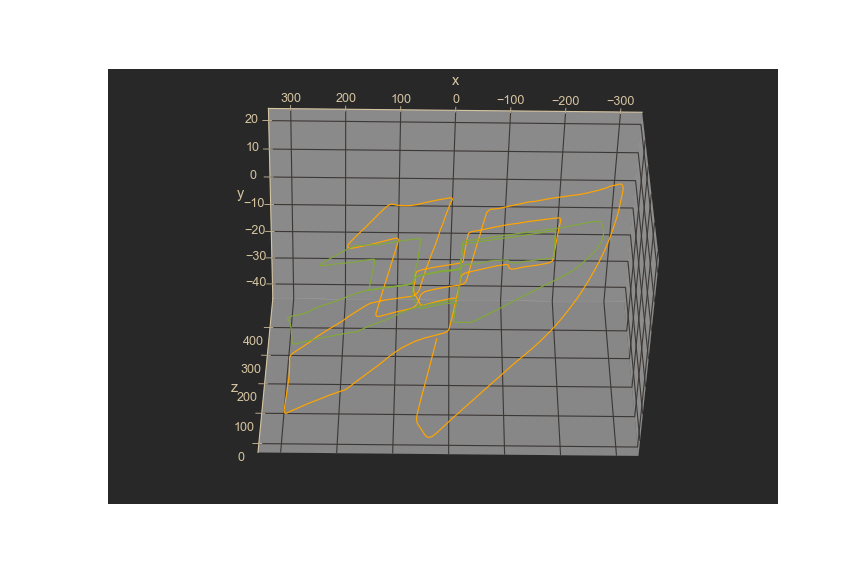

Text(0.5, 0, 'z')

In [204]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 1], 
        trajectory[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [471]:
from importlib import reload
reload(plt)
%matplotlib notebook

In [473]:
%matplotlib inline

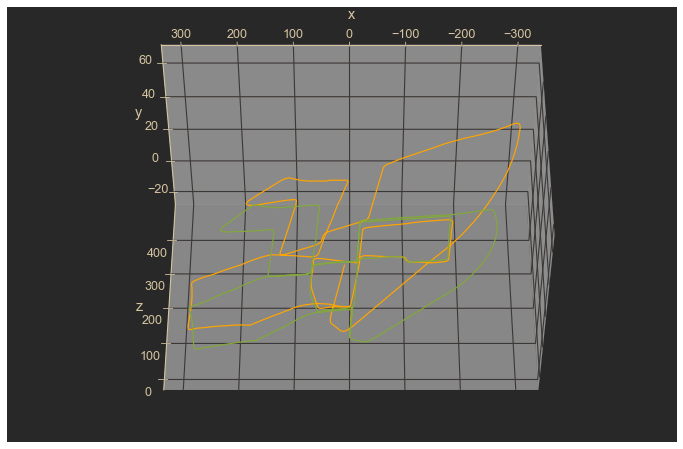

In [485]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 1], 
        trajectory[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=90)

In [417]:
jtplot.style()

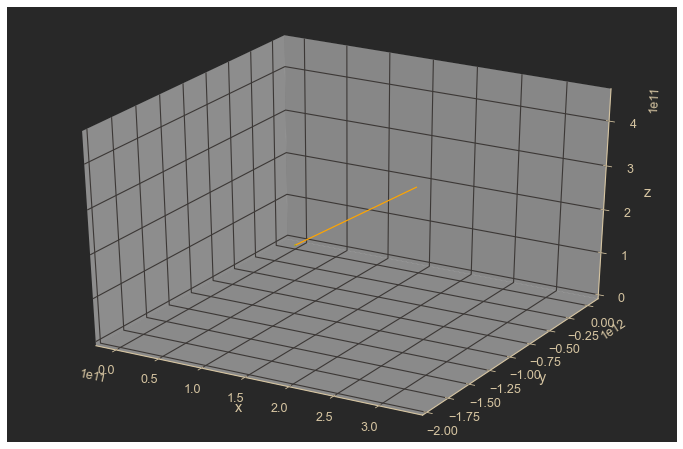

In [426]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_lidar[:, :, 3][:, 0], 
        trajectory_lidar[:, :, 3][:, 1], 
        trajectory_lidar[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

These results aren't terrible, considering that only stereo depth and visual odometry were being used without any help from the LIDAR or a vehicle model, but they need to be improved. Similarly, the computation time was not acceptable, and we'll need more efficient methods. Using a FLANN based matcher instead of brute force should help. If that is still not enough, we can move away from SIFT, but in my experience ORB is nowhere near as good.

In [163]:
start = datetime.datetime.now()
trajectory_flann = visual_odometry(handler, 
                                   filter_match_distance=0.5, 
                                   matching='FLANN',
                                   subset=20)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Detecting features with sift and matching with FLANN
Time to compute frame 1: 0:00:00.683061
Time to compute frame 2: 0:00:00.650467
Time to compute frame 3: 0:00:00.668143
Time to compute frame 4: 0:00:00.666739
Time to compute frame 5: 0:00:00.643509
Time to compute frame 6: 0:00:00.761071
Time to compute frame 7: 0:00:00.822944
Time to compute frame 8: 0:00:00.827040
Time to compute frame 9: 0:00:00.687773
Time to compute frame 10: 0:00:00.704054
Time to compute frame 11: 0:00:00.661148
Time to compute frame 12: 0:00:00.634072
Time to compute frame 13: 0:00:00.611965
Time to compute frame 14: 0:00:00.601030
Time to compute frame 15: 0:00:00.612114
Time to compute frame 16: 0:00:00.632115
Time to compute frame 17: 0:00:00.615032
Time to compute frame 18: 0:00:00.614998
Time to compute frame 19: 0:00:00.615014
Time to perform odometry: 0:00:12.726282


In [507]:
# Changing to FLANN does not demonstrate any appreciable speed increase, in fact it seems slower
start = datetime.datetime.now()
trajectory_orb = visual_odometry(handler, 
                                   filter_match_distance=0.3, 
                                   detector='orb',
                                   subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with ORB and matching with BF
Filtering feature matches at threshold of 0.3*distance
Time to compute frame 1: 0:00:00.104997
Time to compute frame 2: 0:00:00.104994
Time to compute frame 3: 0:00:00.095028
Time to compute frame 4: 0:00:00.103997
Time to compute frame 5: 0:00:00.108005
Time to compute frame 6: 0:00:00.123003
Time to compute frame 7: 0:00:00.117001
Time to compute frame 8: 0:00:00.094011
Time to compute frame 9: 0:00:00.107000
Time to compute frame 10: 0:00:00.097997
Time to compute frame 11: 0:00:00.105001
Time to compute frame 12: 0:00:00.099004
Time to compute frame 13: 0:00:00.105999
Time to compute frame 14: 0:00:00.102998
Time to compute frame 15: 0:00:00.104004
Time to compute frame 16: 0:00:00.099996
Time to compute frame 17: 0:00:00.093999
Time to compute frame 18: 0:00:00.093001
Time to compute frame 19: 0:00:00.093032
Time to compute frame 20: 0:00:00.100000
Time to compute frame 21: 0:00:00.108031
Time to

Time to compute frame 198: 0:00:00.096005
Time to compute frame 199: 0:00:00.089000
Time to compute frame 200: 0:00:00.088966
Time to compute frame 201: 0:00:00.092001
Time to compute frame 202: 0:00:00.099033
Time to compute frame 203: 0:00:00.109972
Time to compute frame 204: 0:00:00.098999
Time to compute frame 205: 0:00:00.100001
Time to compute frame 206: 0:00:00.100026
Time to compute frame 207: 0:00:00.100003
Time to compute frame 208: 0:00:00.103995
Time to compute frame 209: 0:00:00.099999
Time to compute frame 210: 0:00:00.100001
Time to compute frame 211: 0:00:00.095998
Time to compute frame 212: 0:00:00.092001
Time to compute frame 213: 0:00:00.099000
Time to compute frame 214: 0:00:00.090997
Time to compute frame 215: 0:00:00.090003
Time to compute frame 216: 0:00:00.093003
Time to compute frame 217: 0:00:00.088995
Time to compute frame 218: 0:00:00.089006
Time to compute frame 219: 0:00:00.086995
Time to compute frame 220: 0:00:00.098002
Time to compute frame 221: 0:00:00

Time to compute frame 396: 0:00:00.098999
Time to compute frame 397: 0:00:00.106997
Time to compute frame 398: 0:00:00.090999
Time to compute frame 399: 0:00:00.084992
Time to compute frame 400: 0:00:00.083033
Time to compute frame 401: 0:00:00.088963
Time to compute frame 402: 0:00:00.090998
Time to compute frame 403: 0:00:00.082000
Time to compute frame 404: 0:00:00.083005
Time to compute frame 405: 0:00:00.085002
Time to compute frame 406: 0:00:00.101004
Time to compute frame 407: 0:00:00.096997
Time to compute frame 408: 0:00:00.086005
Time to compute frame 409: 0:00:00.087000
Time to compute frame 410: 0:00:00.091000
Time to compute frame 411: 0:00:00.082999
Time to compute frame 412: 0:00:00.093002
Time to compute frame 413: 0:00:00.085005
Time to compute frame 414: 0:00:00.094995
Time to compute frame 415: 0:00:00.090030
Time to compute frame 416: 0:00:00.083967
Time to compute frame 417: 0:00:00.099001
Time to compute frame 418: 0:00:00.095000
Time to compute frame 419: 0:00:00

Time to compute frame 593: 0:00:00.095004
Time to compute frame 594: 0:00:00.091000
Time to compute frame 595: 0:00:00.093005
Time to compute frame 596: 0:00:00.093030
Time to compute frame 597: 0:00:00.095966
Time to compute frame 598: 0:00:00.091034
Time to compute frame 599: 0:00:00.094002
Time to compute frame 600: 0:00:00.096962
Time to compute frame 601: 0:00:00.089004
Time to compute frame 602: 0:00:00.088032
Time to compute frame 603: 0:00:00.088000
Time to compute frame 604: 0:00:00.090999
Time to compute frame 605: 0:00:00.090996
Time to compute frame 606: 0:00:00.091006
Time to compute frame 607: 0:00:00.090999
Time to compute frame 608: 0:00:00.091001
Time to compute frame 609: 0:00:00.086513
Time to compute frame 610: 0:00:00.087002
Time to compute frame 611: 0:00:00.093004
Time to compute frame 612: 0:00:00.082035
Time to compute frame 613: 0:00:00.081970
Time to compute frame 614: 0:00:00.119995
Time to compute frame 615: 0:00:00.082997
Time to compute frame 616: 0:00:00

Time to compute frame 789: 0:00:00.096001
Time to compute frame 790: 0:00:00.093996
Time to compute frame 791: 0:00:00.091033
Time to compute frame 792: 0:00:00.096966
Time to compute frame 793: 0:00:00.111000
Time to compute frame 794: 0:00:00.095006
Time to compute frame 795: 0:00:00.093001
Time to compute frame 796: 0:00:00.115002
Time to compute frame 797: 0:00:00.095966
Time to compute frame 798: 0:00:00.098999
Time to compute frame 799: 0:00:00.091001
Time to compute frame 800: 0:00:00.093000
Time to compute frame 801: 0:00:00.092999
Time to compute frame 802: 0:00:00.093001
Time to compute frame 803: 0:00:00.091997
Time to compute frame 804: 0:00:00.097001
Time to compute frame 805: 0:00:00.091975
Time to compute frame 806: 0:00:00.098994
Time to compute frame 807: 0:00:00.112999
Time to compute frame 808: 0:00:00.122999
Time to compute frame 809: 0:00:00.090000
Time to compute frame 810: 0:00:00.089995
Time to compute frame 811: 0:00:00.096002
Time to compute frame 812: 0:00:00

Time to compute frame 985: 0:00:00.110003
Time to compute frame 986: 0:00:00.091003
Time to compute frame 987: 0:00:00.093998
Time to compute frame 988: 0:00:00.093998
Time to compute frame 989: 0:00:00.110000
Time to compute frame 990: 0:00:00.110003
Time to compute frame 991: 0:00:00.114001
Time to compute frame 992: 0:00:00.099003
Time to compute frame 993: 0:00:00.090028
Time to compute frame 994: 0:00:00.111968
Time to compute frame 995: 0:00:00.121002
Time to compute frame 996: 0:00:00.108003
Time to compute frame 997: 0:00:00.116997
Time to compute frame 998: 0:00:00.114998
Time to compute frame 999: 0:00:00.103004
Time to compute frame 1000: 0:00:00.100996
Time to compute frame 1001: 0:00:00.091006
Time to compute frame 1002: 0:00:00.098000
Time to compute frame 1003: 0:00:00.100998
Time to compute frame 1004: 0:00:00.094998
Time to compute frame 1005: 0:00:00.094004
Time to compute frame 1006: 0:00:00.089000
Time to compute frame 1007: 0:00:00.098997
Time to compute frame 1008

Time to compute frame 1177: 0:00:00.112001
Time to compute frame 1178: 0:00:00.091034
Time to compute frame 1179: 0:00:00.091999
Time to compute frame 1180: 0:00:00.096993
Time to compute frame 1181: 0:00:00.093001
Time to compute frame 1182: 0:00:00.110064
Time to compute frame 1183: 0:00:00.092987
Time to compute frame 1184: 0:00:00.097005
Time to compute frame 1185: 0:00:00.095021
Time to compute frame 1186: 0:00:00.101020
Time to compute frame 1187: 0:00:00.113014
Time to compute frame 1188: 0:00:00.105997
Time to compute frame 1189: 0:00:00.104000
Time to compute frame 1190: 0:00:00.102999
Time to compute frame 1191: 0:00:00.105031
Time to compute frame 1192: 0:00:00.101001
Time to compute frame 1193: 0:00:00.090998
Time to compute frame 1194: 0:00:00.095000
Time to compute frame 1195: 0:00:00.095034
Time to compute frame 1196: 0:00:00.096207
Time to compute frame 1197: 0:00:00.090966
Time to compute frame 1198: 0:00:00.093002
Time to compute frame 1199: 0:00:00.104011
Time to com

Time to compute frame 1368: 0:00:00.087999
Time to compute frame 1369: 0:00:00.091002
Time to compute frame 1370: 0:00:00.093000
Time to compute frame 1371: 0:00:00.102004
Time to compute frame 1372: 0:00:00.101998
Time to compute frame 1373: 0:00:00.087999
Time to compute frame 1374: 0:00:00.096999
Time to compute frame 1375: 0:00:00.089999
Time to compute frame 1376: 0:00:00.084999
Time to compute frame 1377: 0:00:00.101003
Time to compute frame 1378: 0:00:00.091037
Time to compute frame 1379: 0:00:00.083997
Time to compute frame 1380: 0:00:00.087001
Time to compute frame 1381: 0:00:00.087001
Time to compute frame 1382: 0:00:00.104002
Time to compute frame 1383: 0:00:00.088995
Time to compute frame 1384: 0:00:00.089006
Time to compute frame 1385: 0:00:00.094000
Time to compute frame 1386: 0:00:00.088998
Time to compute frame 1387: 0:00:00.093001
Time to compute frame 1388: 0:00:00.106997
Time to compute frame 1389: 0:00:00.089998
Time to compute frame 1390: 0:00:00.098003
Time to com

Time to compute frame 1749: 0:00:00.107998
Time to compute frame 1750: 0:00:00.119001
Time to compute frame 1751: 0:00:00.113000
Time to compute frame 1752: 0:00:00.105002
Time to compute frame 1753: 0:00:00.128999
Time to compute frame 1754: 0:00:00.108999
Time to compute frame 1755: 0:00:00.101002
Time to compute frame 1756: 0:00:00.112997
Time to compute frame 1757: 0:00:00.117000
Time to compute frame 1758: 0:00:00.101005
Time to compute frame 1759: 0:00:00.105996
Time to compute frame 1760: 0:00:00.098997
Time to compute frame 1761: 0:00:00.100002
Time to compute frame 1762: 0:00:00.120000
Time to compute frame 1763: 0:00:00.112000
Time to compute frame 1764: 0:00:00.099999
Time to compute frame 1765: 0:00:00.095002
Time to compute frame 1766: 0:00:00.087000
Time to compute frame 1767: 0:00:00.102000
Time to compute frame 1768: 0:00:00.095999
Time to compute frame 1769: 0:00:00.090041
Time to compute frame 1770: 0:00:00.096963
Time to compute frame 1771: 0:00:00.104002
Time to com

Time to compute frame 1941: 0:00:00.091997
Time to compute frame 1942: 0:00:00.089002
Time to compute frame 1943: 0:00:00.101002
Time to compute frame 1944: 0:00:00.091001
Time to compute frame 1945: 0:00:00.096033
Time to compute frame 1946: 0:00:00.097967
Time to compute frame 1947: 0:00:00.089999
Time to compute frame 1948: 0:00:00.099003
Time to compute frame 1949: 0:00:00.103999
Time to compute frame 1950: 0:00:00.101005
Time to compute frame 1951: 0:00:00.095996
Time to compute frame 1952: 0:00:00.097001
Time to compute frame 1953: 0:00:00.115000
Time to compute frame 1954: 0:00:00.097005
Time to compute frame 1955: 0:00:00.096003
Time to compute frame 1956: 0:00:00.091996
Time to compute frame 1957: 0:00:00.096999
Time to compute frame 1958: 0:00:00.096998
Time to compute frame 1959: 0:00:00.100004
Time to compute frame 1960: 0:00:00.093994
Time to compute frame 1961: 0:00:00.097003
Time to compute frame 1962: 0:00:00.099998
Time to compute frame 1963: 0:00:00.103037
Time to com

Time to compute frame 2323: 0:00:00.098006
Time to compute frame 2324: 0:00:00.102963
Time to compute frame 2325: 0:00:00.110997
Time to compute frame 2326: 0:00:00.103001
Time to compute frame 2327: 0:00:00.108034
Time to compute frame 2328: 0:00:00.099996
Time to compute frame 2329: 0:00:00.102002
Time to compute frame 2330: 0:00:00.104962
Time to compute frame 2331: 0:00:00.095039
Time to compute frame 2332: 0:00:00.100001
Time to compute frame 2333: 0:00:00.095995
Time to compute frame 2334: 0:00:00.101005
Time to compute frame 2335: 0:00:00.098995
Time to compute frame 2336: 0:00:00.098004
Time to compute frame 2337: 0:00:00.094997
Time to compute frame 2338: 0:00:00.104036
Time to compute frame 2339: 0:00:00.092966
Time to compute frame 2340: 0:00:00.100032
Time to compute frame 2341: 0:00:00.100001
Time to compute frame 2342: 0:00:00.095006
Time to compute frame 2343: 0:00:00.096032
Time to compute frame 2344: 0:00:00.094000
Time to compute frame 2345: 0:00:00.097003
Time to com

Time to compute frame 2514: 0:00:00.108994
Time to compute frame 2515: 0:00:00.091000
Time to compute frame 2516: 0:00:00.085999
Time to compute frame 2517: 0:00:00.086001
Time to compute frame 2518: 0:00:00.101001
Time to compute frame 2519: 0:00:00.092996
Time to compute frame 2520: 0:00:00.091001
Time to compute frame 2521: 0:00:00.085000
Time to compute frame 2522: 0:00:00.094001
Time to compute frame 2523: 0:00:00.097001
Time to compute frame 2524: 0:00:00.083997
Time to compute frame 2525: 0:00:00.086036
Time to compute frame 2526: 0:00:00.089031
Time to compute frame 2527: 0:00:00.083962
Time to compute frame 2528: 0:00:00.089036
Time to compute frame 2529: 0:00:00.094970
Time to compute frame 2530: 0:00:00.089003
Time to compute frame 2531: 0:00:00.082031
Time to compute frame 2532: 0:00:00.084969
Time to compute frame 2533: 0:00:00.088997
Time to compute frame 2534: 0:00:00.087996
Time to compute frame 2535: 0:00:00.089000
Time to compute frame 2536: 0:00:00.085031
Time to com

Time to compute frame 2896: 0:00:00.101002
Time to compute frame 2897: 0:00:00.086999
Time to compute frame 2898: 0:00:00.085971
Time to compute frame 2899: 0:00:00.084000
Time to compute frame 2900: 0:00:00.091032
Time to compute frame 2901: 0:00:00.092966
Time to compute frame 2902: 0:00:00.082038
Time to compute frame 2903: 0:00:00.084963
Time to compute frame 2904: 0:00:00.088000
Time to compute frame 2905: 0:00:00.083003
Time to compute frame 2906: 0:00:00.081006
Time to compute frame 2907: 0:00:00.087992
Time to compute frame 2908: 0:00:00.087000
Time to compute frame 2909: 0:00:00.083000
Time to compute frame 2910: 0:00:00.084005
Time to compute frame 2911: 0:00:00.095997
Time to compute frame 2912: 0:00:00.103010
Time to compute frame 2913: 0:00:00.088000
Time to compute frame 2914: 0:00:00.101999
Time to compute frame 2915: 0:00:00.086029
Time to compute frame 2916: 0:00:00.086968
Time to compute frame 2917: 0:00:00.080030
Time to compute frame 2918: 0:00:00.080003
Time to com

Time to compute frame 3087: 0:00:00.095001
Time to compute frame 3088: 0:00:00.086003
Time to compute frame 3089: 0:00:00.104997
Time to compute frame 3090: 0:00:00.104997
Time to compute frame 3091: 0:00:00.087003
Time to compute frame 3092: 0:00:00.097994
Time to compute frame 3093: 0:00:00.085003
Time to compute frame 3094: 0:00:00.087998
Time to compute frame 3095: 0:00:00.087004
Time to compute frame 3096: 0:00:00.089997
Time to compute frame 3097: 0:00:00.093005
Time to compute frame 3098: 0:00:00.098995
Time to compute frame 3099: 0:00:00.094002
Time to compute frame 3100: 0:00:00.094000
Time to compute frame 3101: 0:00:00.092997
Time to compute frame 3102: 0:00:00.088999
Time to compute frame 3103: 0:00:00.107003
Time to compute frame 3104: 0:00:00.085999
Time to compute frame 3105: 0:00:00.109971
Time to compute frame 3106: 0:00:00.094012
Time to compute frame 3107: 0:00:00.108987
Time to compute frame 3108: 0:00:00.097998
Time to compute frame 3109: 0:00:00.094005
Time to com

Time to compute frame 3468: 0:00:00.100038
Time to compute frame 3469: 0:00:00.096001
Time to compute frame 3470: 0:00:00.091000
Time to compute frame 3471: 0:00:00.087002
Time to compute frame 3472: 0:00:00.093998
Time to compute frame 3473: 0:00:00.088000
Time to compute frame 3474: 0:00:00.094001
Time to compute frame 3475: 0:00:00.098000
Time to compute frame 3476: 0:00:00.093002
Time to compute frame 3477: 0:00:00.094000
Time to compute frame 3478: 0:00:00.088002
Time to compute frame 3479: 0:00:00.099035
Time to compute frame 3480: 0:00:00.094964
Time to compute frame 3481: 0:00:00.091006
Time to compute frame 3482: 0:00:00.087998
Time to compute frame 3483: 0:00:00.100000
Time to compute frame 3484: 0:00:00.087000
Time to compute frame 3485: 0:00:00.098000
Time to compute frame 3486: 0:00:00.103968
Time to compute frame 3487: 0:00:00.117998
Time to compute frame 3488: 0:00:00.115998
Time to compute frame 3489: 0:00:00.092999
Time to compute frame 3490: 0:00:00.095001
Time to com

Time to compute frame 3661: 0:00:00.099005
Time to compute frame 3662: 0:00:00.098000
Time to compute frame 3663: 0:00:00.089998
Time to compute frame 3664: 0:00:00.092001
Time to compute frame 3665: 0:00:00.093033
Time to compute frame 3666: 0:00:00.087029
Time to compute frame 3667: 0:00:00.092969
Time to compute frame 3668: 0:00:00.091003
Time to compute frame 3669: 0:00:00.093000
Time to compute frame 3670: 0:00:00.085998
Time to compute frame 3671: 0:00:00.086996
Time to compute frame 3672: 0:00:00.097002
Time to compute frame 3673: 0:00:00.106004
Time to compute frame 3674: 0:00:00.097032
Time to compute frame 3675: 0:00:00.093995
Time to compute frame 3676: 0:00:00.092968
Time to compute frame 3677: 0:00:00.089965
Time to compute frame 3678: 0:00:00.089002
Time to compute frame 3679: 0:00:00.092033
Time to compute frame 3680: 0:00:00.091994
Time to compute frame 3681: 0:00:00.106000
Time to compute frame 3682: 0:00:00.111002
Time to compute frame 3683: 0:00:00.130999
Time to com

Time to compute frame 3852: 0:00:00.094999
Time to compute frame 3853: 0:00:00.092031
Time to compute frame 3854: 0:00:00.085967
Time to compute frame 3855: 0:00:00.088000
Time to compute frame 3856: 0:00:00.088038
Time to compute frame 3857: 0:00:00.099966
Time to compute frame 3858: 0:00:00.086996
Time to compute frame 3859: 0:00:00.088029
Time to compute frame 3860: 0:00:00.094003
Time to compute frame 3861: 0:00:00.087031
Time to compute frame 3862: 0:00:00.097966
Time to compute frame 3863: 0:00:00.087003
Time to compute frame 3864: 0:00:00.088995
Time to compute frame 3865: 0:00:00.087998
Time to compute frame 3866: 0:00:00.089026
Time to compute frame 3867: 0:00:00.087009
Time to compute frame 3868: 0:00:00.098970
Time to compute frame 3869: 0:00:00.085998
Time to compute frame 3870: 0:00:00.087000
Time to compute frame 3871: 0:00:00.098000
Time to compute frame 3872: 0:00:00.084999
Time to compute frame 3873: 0:00:00.093998
Time to compute frame 3874: 0:00:00.093004
Time to com

Time to compute frame 4043: 0:00:00.095001
Time to compute frame 4044: 0:00:00.092999
Time to compute frame 4045: 0:00:00.092000
Time to compute frame 4046: 0:00:00.097031
Time to compute frame 4047: 0:00:00.094997
Time to compute frame 4048: 0:00:00.091005
Time to compute frame 4049: 0:00:00.093997
Time to compute frame 4050: 0:00:00.093035
Time to compute frame 4051: 0:00:00.107003
Time to compute frame 4052: 0:00:00.091028
Time to compute frame 4053: 0:00:00.096037
Time to compute frame 4054: 0:00:00.089997
Time to compute frame 4055: 0:00:00.095960
Time to compute frame 4056: 0:00:00.088034
Time to compute frame 4057: 0:00:00.092968
Time to compute frame 4058: 0:00:00.094029
Time to compute frame 4059: 0:00:00.096032
Time to compute frame 4060: 0:00:00.090967
Time to compute frame 4061: 0:00:00.090998
Time to compute frame 4062: 0:00:00.092002
Time to compute frame 4063: 0:00:00.094997
Time to compute frame 4064: 0:00:00.092004
Time to compute frame 4065: 0:00:00.086996
Time to com

Time to compute frame 4234: 0:00:00.091003
Time to compute frame 4235: 0:00:00.089997
Time to compute frame 4236: 0:00:00.098006
Time to compute frame 4237: 0:00:00.089996
Time to compute frame 4238: 0:00:00.094996
Time to compute frame 4239: 0:00:00.092000
Time to compute frame 4240: 0:00:00.090004
Time to compute frame 4241: 0:00:00.090030
Time to compute frame 4242: 0:00:00.091967
Time to compute frame 4243: 0:00:00.100999
Time to compute frame 4244: 0:00:00.092000
Time to compute frame 4245: 0:00:00.089996
Time to compute frame 4246: 0:00:00.095001
Time to compute frame 4247: 0:00:00.093004
Time to compute frame 4248: 0:00:00.092999
Time to compute frame 4249: 0:00:00.089007
Time to compute frame 4250: 0:00:00.090994
Time to compute frame 4251: 0:00:00.094998
Time to compute frame 4252: 0:00:00.109041
Time to compute frame 4253: 0:00:00.096998
Time to compute frame 4254: 0:00:00.095034
Time to compute frame 4255: 0:00:00.088967
Time to compute frame 4256: 0:00:00.091997
Time to com

Time to compute frame 4426: 0:00:00.129998
Time to compute frame 4427: 0:00:00.118002
Time to compute frame 4428: 0:00:00.096998
Time to compute frame 4429: 0:00:00.107000
Time to compute frame 4430: 0:00:00.091000
Time to compute frame 4431: 0:00:00.098003
Time to compute frame 4432: 0:00:00.098997
Time to compute frame 4433: 0:00:00.107996
Time to compute frame 4434: 0:00:00.113006
Time to compute frame 4435: 0:00:00.091002
Time to compute frame 4436: 0:00:00.107996
Time to compute frame 4437: 0:00:00.098002
Time to compute frame 4438: 0:00:00.088002
Time to compute frame 4439: 0:00:00.086002
Time to compute frame 4440: 0:00:00.091998
Time to compute frame 4441: 0:00:00.088033
Time to compute frame 4442: 0:00:00.088970
Time to compute frame 4443: 0:00:00.096003
Time to compute frame 4444: 0:00:00.102995
Time to compute frame 4445: 0:00:00.097001
Time to compute frame 4446: 0:00:00.106000
Time to compute frame 4447: 0:00:00.093002
Time to compute frame 4448: 0:00:00.114999
Time to com

Text(0.5, 0, 'z')

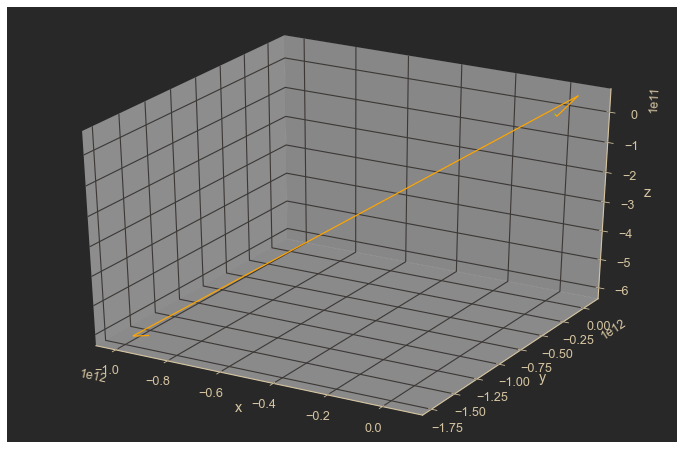

In [508]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_orb[:, :, 3][:, 0], 
        trajectory_orb[:, :, 3][:, 1], 
        trajectory_orb[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [509]:
for row in trajectory_orb:
    print(row)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
[[ 9.99988241e-01 -2.87125796e-03 -3.90827140e-03  2.06139660e-02]
 [ 2.86175663e-03  9.99992942e-01 -2.43450856e-03  6.29447665e-04]
 [ 3.91523392e-03  2.42329541e-03  9.99989399e-01  7.10684137e-01]]
[[ 0.99998685 -0.00202681 -0.00471136 -0.10274288]
 [ 0.00201123  0.9999925  -0.00330869 -0.01385514]
 [ 0.00471803  0.00329917  0.99998343  1.24860316]]
[[ 9.99965844e-01 -2.00336640e-03 -8.01854642e-03 -1.20911332e-01]
 [ 1.96466575e-03  9.99986399e-01 -4.83136211e-03 -1.64350624e-02]
 [ 8.02811635e-03  4.81544333e-03  9.99956179e-01  1.96655119e+00]]
[[ 9.99916930e-01 -1.22176597e-03 -1.28312643e-02 -1.39038155e-01]
 [ 1.15397723e-03  9.99985346e-01 -5.28916709e-03 -4.06352587e-02]
 [ 1.28375384e-02  5.27392073e-03  9.99903687e-01  2.66512350e+00]]
[[ 9.99862348e-01 -2.01634704e-03 -1.64687282e-02 -1.76194127e-01]
 [ 1.91609571e-03  9.99979554e-01 -6.10088752e-03 -3.00751117e-02]
 [ 1.64806930e-02  6.06849207e-03  9.99845768e-01  3.3835813

 [ 9.92622422e-01  5.77345356e-03  1.21109017e-01 -7.00903189e+02]]
[[-3.68483385e-02 -9.43494591e-01  3.29332897e-01 -1.16569327e+03]
 [ 1.18387293e-01 -3.31357412e-01 -9.36048457e-01 -1.42640931e+03]
 [ 9.92283553e-01  4.49699975e-03  1.23907741e-01 -7.00781518e+02]]
[[-4.03524120e-02 -9.43343403e-01  3.29355289e-01 -1.16556596e+03]
 [ 1.24029357e-01 -3.31803447e-01 -9.35159447e-01 -1.42679239e+03]
 [ 9.91457715e-01  3.11378524e-03  1.30391345e-01 -7.00733170e+02]]
[[-4.40970805e-02 -9.43166500e-01  3.29381847e-01 -1.16541708e+03]
 [ 1.29005269e-01 -3.32318047e-01 -9.34303139e-01 -1.42715822e+03]
 [ 9.90662954e-01  1.29195289e-03  1.36327703e-01 -7.00673197e+02]]
[[-4.75555247e-02 -9.42969800e-01  3.29463849e-01 -1.16528195e+03]
 [ 1.33506126e-01 -3.32878042e-01 -9.33471116e-01 -1.42746167e+03]
 [ 9.89906352e-01 -4.06266640e-04  1.41722435e-01 -7.00611297e+02]]
[[-5.05682540e-02 -9.42830967e-01  3.29412536e-01 -1.16515207e+03]
 [ 1.38985796e-01 -3.33268484e-01 -9.32531536e-01 -1.4277

 [ 3.86058702e-01  5.88273211e-01 -7.10558447e-01 -3.14929963e+02]]
[[ 4.80068682e-01 -7.86229468e-01 -3.89072338e-01 -1.17370873e+03]
 [-7.86336701e-01 -1.89082258e-01 -5.88151760e-01 -1.34656106e+03]
 [ 3.88855569e-01  5.88295099e-01 -7.09013556e-01 -3.15536407e+02]]
[[ 4.82036735e-01 -7.86322950e-01 -3.86441206e-01 -1.17405297e+03]
 [-7.82082103e-01 -1.87342153e-01 -5.94348805e-01 -1.34691395e+03]
 [ 3.94953378e-01  5.88726708e-01 -7.05274906e-01 -3.16150474e+02]]
[[ 4.82907853e-01 -7.86463368e-01 -3.85065419e-01 -1.17437589e+03]
 [-7.79295956e-01 -1.85425186e-01 -5.98594448e-01 -1.34743354e+03]
 [ 3.99371778e-01  5.89145884e-01 -7.02431001e-01 -3.16803181e+02]]
[[ 4.84815040e-01 -7.85964323e-01 -3.83685366e-01 -1.17471542e+03]
 [-7.76633968e-01 -1.85111832e-01 -6.02140590e-01 -1.34796663e+03]
 [ 4.02236320e-01  5.89909902e-01 -7.00151591e-01 -3.17413488e+02]]
[[ 4.85069495e-01 -7.85378297e-01 -3.84562759e-01 -1.17499271e+03]
 [-7.74997192e-01 -1.82380794e-01 -6.05075696e-01 -1.3484

 [ 9.23361111e-01  3.71480055e-01  9.69888064e-02 -5.97131165e+07]]
[[ 8.01948222e-02  9.96415238e-01  2.69344522e-02  2.42308630e+08]
 [-9.32513595e-01  6.54515065e-02  3.55154186e-01  2.69793620e+07]
 [ 3.52118143e-01 -5.35982697e-02  9.34419627e-01 -5.97129307e+07]]
[[-1.20209375e-02 -9.89676658e-01 -1.42813201e-01  2.42308620e+08]
 [ 9.86806104e-01 -3.48034705e-02  1.58121572e-01  2.69793983e+07]
 [-1.61459624e-01 -1.39028169e-01  9.77037337e-01 -5.97127920e+07]]
[[-9.94676939e-02 -9.59917957e-01 -2.62037581e-01  2.42308628e+08]
 [ 9.84411582e-01 -1.33320494e-01  1.14714789e-01  2.69794011e+07]
 [-1.45051765e-01 -2.46542414e-01  9.58215437e-01 -5.97127904e+07]]
[[-2.04151704e-01  1.21156617e-01 -9.71412969e-01  2.42308456e+08]
 [-1.07880650e-01  9.83483467e-01  1.45334222e-01  2.69794276e+07]
 [ 9.72976797e-01  1.34466891e-01 -1.87709371e-01 -5.97127666e+07]]
[[-3.34390810e-01  6.28866196e-01  7.01933112e-01  2.42308366e+08]
 [ 2.77085964e-02  7.51046710e-01 -6.59667395e-01  2.6979

[[-3.68211190e-01 -7.58969771e-01  5.37015276e-01  2.42308375e+08]
 [-8.55939460e-01  5.02246932e-01  1.22945761e-01  2.69795188e+07]
 [-3.63026391e-01 -4.14382560e-01 -8.34565116e-01 -5.97127601e+07]]
[[-3.68613190e-01 -7.53503661e-01  5.44386397e-01  2.42308375e+08]
 [-8.54945560e-01  5.04717938e-01  1.19699176e-01  2.69795190e+07]
 [-3.64955347e-01 -4.21298038e-01 -8.30250298e-01 -5.97127610e+07]]
[[-3.72711405e-01 -7.51055074e-01  5.44979343e-01  2.42308376e+08]
 [-8.51809148e-01  5.09888940e-01  1.20143436e-01  2.69795190e+07]
 [-3.68113277e-01 -4.19439561e-01 -8.29797006e-01 -5.97127616e+07]]
[[-3.73910018e-01 -7.54220708e-01  5.39761450e-01  2.42308376e+08]
 [-8.51118499e-01  5.10263155e-01  1.23405079e-01  2.69795191e+07]
 [-3.68495046e-01 -4.13258560e-01 -8.32723702e-01 -5.97127624e+07]]
[[-3.76884853e-01 -7.06081420e-01  5.99505494e-01  2.42308420e+08]
 [-8.30168202e-01  5.44560659e-01  1.19475707e-01  2.69795310e+07]
 [-4.10826683e-01 -4.52661814e-01 -7.91403006e-01 -5.97128

 [ 8.03170734e-01 -5.79798505e-01 -1.36932339e-01 -5.97128295e+07]]
[[ 4.07495526e-01  3.83462853e-01  8.28796499e-01  2.42308423e+08]
 [-4.19535443e-01 -7.27513723e-01  5.42875488e-01  2.69802637e+07]
 [ 8.11133410e-01 -5.68928839e-01 -1.35582329e-01 -5.97128298e+07]]
[[ 4.08231358e-01  3.86603942e-01  8.26973126e-01  2.42308423e+08]
 [-4.20177052e-01 -7.24656812e-01  5.46190214e-01  2.69802643e+07]
 [ 8.10430999e-01 -5.70447103e-01 -1.33385530e-01 -5.97128299e+07]]
[[ 4.00684647e-01  3.95127754e-01  8.26635271e-01  2.42308424e+08]
 [-4.15026224e-01 -7.26080657e-01  5.48233630e-01  2.69802650e+07]
 [ 8.16826204e-01 -5.62744114e-01 -1.26940992e-01 -5.97128301e+07]]
[[ 4.08206218e-01  3.96802315e-01  8.22140868e-01  2.42308425e+08]
 [-4.18849557e-01 -7.18793757e-01  5.54887901e-01  2.69802654e+07]
 [ 8.11130527e-01 -5.70862030e-01 -1.27215607e-01 -5.97128302e+07]]
[[ 4.11221566e-01  3.95176616e-01  8.21420882e-01  2.42308426e+08]
 [-4.17814814e-01 -7.19185869e-01  5.55159858e-01  2.6980

 [-3.15397491e-01 -2.66638541e-01 -9.10729549e-01  6.15941418e+10]]
[[-5.61981654e-01  8.25522803e-01 -5.18528906e-02  6.67601495e+10]
 [ 7.66715788e-01  4.96375272e-01 -4.07134485e-01  4.78129507e+10]
 [-3.10360309e-01 -2.68558541e-01 -9.11895163e-01  6.15941418e+10]]
[[-5.61404090e-01  8.25339707e-01 -6.03308877e-02  6.67601495e+10]
 [ 7.70831000e-01  4.95016406e-01 -4.00971727e-01  4.78129507e+10]
 [-3.01073109e-01 -2.71612086e-01 -9.14101667e-01  6.15941418e+10]]
[[-5.60899715e-01  8.25056218e-01 -6.83648092e-02  6.67601495e+10]
 [ 7.75437002e-01  4.94647843e-01 -3.92455051e-01  4.78129507e+10]
 [-2.89980975e-01 -2.73140529e-01 -9.17226954e-01  6.15941418e+10]]
[[-5.62279089e-01  8.23437541e-01 -7.61107192e-02  6.67601495e+10]
 [ 7.78607636e-01  4.96156820e-01 -3.84185580e-01  4.78129507e+10]
 [-2.78589977e-01 -2.75279905e-01 -9.20113362e-01  6.15941418e+10]]
[[-5.63262924e-01  8.22490753e-01 -7.90179683e-02  6.67601495e+10]
 [ 7.80927797e-01  4.98662376e-01 -3.76148389e-01  4.7812

 [ 8.94988041e-01  4.22572147e-01  1.42930710e-01  6.16193425e+10]]
[[-2.10756845e-01  1.52293758e-02  9.77419878e-01  6.67806811e+10]
 [-4.19753109e-01  9.01595839e-01 -1.04557504e-01  4.78257576e+10]
 [-8.82830040e-01 -4.32311242e-01 -1.83624916e-01  6.16193425e+10]]
[[-2.08166824e-01  1.67543636e-02  9.77949827e-01  6.67806811e+10]
 [-4.19743096e-01  9.01573209e-01 -1.04792567e-01  4.78257576e+10]
 [-8.83449097e-01 -4.32302024e-01 -1.80645103e-01  6.16193425e+10]]
[[-1.70019384e-01 -9.46962222e-02  9.80880235e-01  6.67806811e+10]
 [ 4.55624430e-01 -8.90144885e-01 -6.96147463e-03  4.78257576e+10]
 [ 8.73784749e-01  4.45729412e-01  1.94487797e-01  6.16193425e+10]]
[[-1.66437970e-01 -8.99538319e-02  9.81940278e-01  6.67806811e+10]
 [ 4.52306692e-01 -8.91848252e-01 -5.03509238e-03  4.78257576e+10]
 [ 8.76194647e-01  4.43300128e-01  1.89124133e-01  6.16193425e+10]]
[[-1.61819940e-01 -8.84980838e-02  9.82844035e-01  6.67806811e+10]
 [ 4.54142352e-01 -8.90912477e-01 -5.44822854e-03  4.7825

 [-6.48550527e-01 -3.36875747e-01  6.82566439e-01  6.16218465e+10]]
[[-9.11216328e-02 -8.53041693e-01 -5.13825571e-01  6.65558218e+10]
 [ 7.42334972e-01 -4.02120400e-01  5.35945869e-01  4.82252711e+10]
 [-6.63803915e-01 -3.32594428e-01  6.69884549e-01  6.16218465e+10]]
[[-8.52608900e-02 -8.53499027e-01 -5.14071971e-01  6.65558218e+10]
 [ 7.33742999e-01 -4.02836339e-01  5.47123474e-01  4.82252711e+10]
 [-6.74056224e-01 -3.30548475e-01  6.60595120e-01  6.16218465e+10]]
[[-8.46454311e-02 -8.53293632e-01 -5.14514459e-01  6.65558218e+10]
 [ 7.28708831e-01 -4.05185648e-01  5.52094222e-01  4.82252711e+10]
 [-6.79572359e-01 -3.28198976e-01  6.56099719e-01  6.16218465e+10]]
[[-5.92652327e-02 -8.83631816e-01 -4.64416242e-01  6.65558218e+10]
 [ 7.10064967e-01 -3.64316669e-01  6.02562119e-01  4.82252712e+10]
 [-7.01637638e-01 -2.94054719e-01  6.49027309e-01  6.16218465e+10]]
[[-5.97183976e-02 -8.82568957e-01 -4.66375116e-01  6.65558218e+10]
 [ 7.11850131e-01 -3.65184506e-01  5.99924719e-01  4.8225

 [ 2.47962997e-01 -7.69092793e-01  5.89076080e-01  6.16396074e+10]]
[[ 9.06847774e-01  3.95874340e-01  1.44605053e-01  6.65747795e+10]
 [-3.46493818e-01  5.04960005e-01  7.90542490e-01  4.82156062e+10]
 [ 2.39935718e-01 -7.67006454e-01  5.95089868e-01  6.16396074e+10]]
[[ 9.03100267e-01  3.98169935e-01  1.60843432e-01  6.65747795e+10]
 [-3.61721800e-01  5.03465497e-01  7.84652683e-01  4.82156062e+10]
 [ 2.31445990e-01 -7.66800623e-01  5.98706571e-01  6.16396074e+10]]
[[ 9.02357761e-01  3.93155271e-01  1.76576905e-01  6.65747795e+10]
 [-3.71987518e-01  5.03552464e-01  7.79782151e-01  4.82156062e+10]
 [ 2.17659727e-01 -7.69326881e-01  6.00633327e-01  6.16396074e+10]]
[[ 9.01842006e-01  3.88274407e-01  1.89536225e-01  6.65747795e+10]
 [-3.80484545e-01  5.05827631e-01  7.74189847e-01  4.82156062e+10]
 [ 2.04725444e-01 -7.70312529e-01  6.03909016e-01  6.16396074e+10]]
[[ 9.01982484e-01  3.83559772e-01  1.98266233e-01  6.65747795e+10]
 [-3.86325131e-01  5.11858154e-01  7.67303149e-01  4.8215

 [ 1.91550507e-01  2.37526883e-01  9.52307399e-01  6.16396076e+10]]
[[-9.79976709e-01 -1.16718830e-03  1.99108731e-01  6.65747795e+10]
 [ 4.93890102e-02 -9.70156486e-01  2.37396543e-01  4.82156059e+10]
 [ 1.92889540e-01  2.42476866e-01  9.50788407e-01  6.16396076e+10]]
[[-9.80271212e-01  1.56964365e-03  1.97650923e-01  6.65747795e+10]
 [ 4.62970884e-02 -9.70327361e-01  2.37321285e-01  4.82156059e+10]
 [ 1.92158609e-01  2.41789886e-01  9.51111308e-01  6.16396076e+10]]
[[-9.80146369e-01  3.70841683e-05  1.98275300e-01  6.65747795e+10]
 [ 4.71191212e-02 -9.71308510e-01  2.33108489e-01  4.82156059e+10]
 [ 1.92595131e-01  2.37822997e-01  9.52022761e-01  6.16396076e+10]]
[[-9.79972747e-01 -2.63096419e-03  1.99114270e-01  6.65747795e+10]
 [ 4.93589352e-02 -9.71917848e-01  2.30085621e-01  4.82156059e+10]
 [ 1.92917365e-01  2.35305706e-01  9.52582865e-01  6.16396076e+10]]
[[-9.79166202e-01  1.70852824e-03  2.03053268e-01  6.65747795e+10]
 [ 4.49801401e-02 -9.73298397e-01  2.25093352e-01  4.8215

 [ 7.62152615e-01  4.91235387e-01 -4.21676636e-01 -6.23651083e+11]]
[[-6.15790664e-01  3.42702822e-01 -7.09476309e-01 -9.98679024e+11]
 [-2.01499458e-01  8.02012829e-01  5.62292975e-01 -1.67069275e+12]
 [ 7.61708492e-01  4.89213857e-01 -4.24817580e-01 -6.23651083e+11]]
[[-6.15694985e-01  3.43387410e-01 -7.09228294e-01 -9.98679024e+11]
 [-1.98490437e-01  8.03445004e-01  5.61317799e-01 -1.67069275e+12]
 [ 7.62575395e-01  4.86375588e-01 -4.26517943e-01 -6.23651083e+11]]
[[-6.16399733e-01  3.44544605e-01 -7.08053942e-01 -9.98679024e+11]
 [-1.98577096e-01  8.02114205e-01  5.63187304e-01 -1.67069275e+12]
 [ 7.61983271e-01  4.87751800e-01 -4.26004315e-01 -6.23651083e+11]]
[[-6.18718232e-01  3.44997251e-01 -7.05807796e-01 -9.98679024e+11]
 [-2.02366334e-01  7.98109938e-01  5.67510699e-01 -1.67069275e+12]
 [ 7.59101848e-01  4.93960953e-01 -4.23989341e-01 -6.23651083e+11]]
[[-6.17936913e-01  3.45793272e-01 -7.06102673e-01 -9.98679024e+11]
 [-2.00203374e-01  7.99280439e-01  5.66629852e-01 -1.6706

 [-5.86694706e-01  4.68604943e-01  6.60453427e-01 -6.24613079e+11]]
[[-6.72852909e-01  2.03291411e-01 -7.11295695e-01 -9.99015070e+11]
 [-4.69769219e-01 -8.60174015e-01  1.98538522e-01 -1.67109983e+12]
 [-5.71476898e-01  4.67732045e-01  6.74270635e-01 -6.24613079e+11]]
[[-6.87854142e-01  2.01998681e-01 -6.97175166e-01 -9.99015070e+11]
 [-4.63444039e-01 -8.61452481e-01  2.07651740e-01 -1.67109983e+12]
 [-5.58637899e-01  4.65935784e-01  6.86168742e-01 -6.24613079e+11]]
[[-7.17238919e-01 -1.09626532e-01 -6.88149952e-01 -9.99015070e+11]
 [-1.89493085e-01 -9.19646910e-01  3.44008622e-01 -1.67109983e+12]
 [-6.70567449e-01  3.77136030e-01  6.38833085e-01 -6.24613079e+11]]
[[-7.30067795e-01 -1.11933351e-01 -6.74145340e-01 -9.99015070e+11]
 [-1.80477678e-01 -9.19888663e-01  3.48184801e-01 -1.67109983e+12]
 [-6.59112147e-01  3.75866695e-01  6.51379617e-01 -6.24613079e+11]]
[[-7.49617543e-01 -2.34807323e-01 -6.18820702e-01 -9.99015070e+11]
 [-5.45838334e-02 -9.09840016e-01  4.11353558e-01 -1.6710

 [-7.54494293e-01 -5.63359555e-01 -3.36696264e-01 -5.99180618e+11]]
[[ 5.69637439e-01 -3.58805623e-01 -7.39440135e-01 -9.20024715e+11]
 [ 3.03946459e-01 -7.43930434e-01  5.95133649e-01 -1.71595873e+12]
 [-7.63629320e-01 -5.63760618e-01 -3.14712929e-01 -5.99180618e+11]]
[[ 5.49133561e-01 -3.62930910e-01 -7.52817034e-01 -9.20024715e+11]
 [ 3.16909020e-01 -7.43082791e-01  5.89403630e-01 -1.71595873e+12]
 [-7.73318179e-01 -5.62235822e-01 -2.93035620e-01 -5.99180618e+11]]
[[ 5.27761926e-01 -3.64084312e-01 -7.67404693e-01 -9.20024715e+11]
 [ 3.31912858e-01 -7.43241035e-01  5.80884342e-01 -1.71595873e+12]
 [-7.81857535e-01 -5.61280123e-01 -2.71410055e-01 -5.99180618e+11]]
[[ 5.07295845e-01 -3.60462816e-01 -7.82762725e-01 -9.20024715e+11]
 [ 3.50069107e-01 -7.43801492e-01  5.69395258e-01 -1.71595873e+12]
 [-7.87465901e-01 -5.62872897e-01 -2.51140511e-01 -5.99180618e+11]]
[[ 4.85278380e-01 -3.53922724e-01 -7.99527110e-01 -9.20024715e+11]
 [ 3.70161418e-01 -7.45268757e-01  5.54576419e-01 -1.7159

In [510]:
cv2.cuda.getCudaEnabledDeviceCount()

0

In [511]:
import tensorflow as tf

In [84]:
!nvidia-smi

Thu Feb 18 17:28:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.40       Driver Version: 461.40       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   42C    P8     7W /  N/A |    596MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [516]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [186]:
# The results form ORB are terrible... there might be something I'm missing about tuning it
# Let's see if adding the mask to the detection process has a noticable impact on time
start = datetime.datetime.now()
trajectory_mask = visual_odometry(handler, filter_match_distance=0.5, mask=mask, subset=30)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Detecting features with sift and matching with BF
Time to compute frame 1: 0:00:00.599630
Time to compute frame 2: 0:00:00.619604
Time to compute frame 3: 0:00:00.623997
Time to compute frame 4: 0:00:00.616231
Time to compute frame 5: 0:00:00.653862
Time to compute frame 6: 0:00:00.622077
Time to compute frame 7: 0:00:00.655214
Time to compute frame 8: 0:00:00.600567
Time to compute frame 9: 0:00:00.657308
Time to compute frame 10: 0:00:00.619044
Time to compute frame 11: 0:00:00.602997
Time to compute frame 12: 0:00:00.574097
Time to compute frame 13: 0:00:00.571633
Time to compute frame 14: 0:00:00.566121
Time to compute frame 15: 0:00:00.549279
Time to compute frame 16: 0:00:00.588042
Time to compute frame 17: 0:00:00.544027
Time to compute frame 18: 0:00:00.571109
Time to compute frame 19: 0:00:00.592052
Time to compute frame 20: 0:00:00.606994
Time to compute frame 21: 0:00:00.583804
Time to compute frame 22: 0:00:00.585508
Time to compute frame 23: 0:00:00.594706
Time to compute 

In [ ]:
# Nope. Let's see if the performance of SIFT improves if we strengthen the distance filtering

In [198]:
start = datetime.datetime.now()
trajectory2 = visual_odometry(handler, filter_match_distance=0.3, subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Detecting features with sift and matching with BF
Time to compute frame 1: 0:00:00.611996
Time to compute frame 2: 0:00:00.616001
Time to compute frame 3: 0:00:00.622998
Time to compute frame 4: 0:00:00.642998
Time to compute frame 5: 0:00:00.624000
Time to compute frame 6: 0:00:00.612998
Time to compute frame 7: 0:00:00.610002
Time to compute frame 8: 0:00:00.630997
Time to compute frame 9: 0:00:00.648000
Time to compute frame 10: 0:00:00.617000
Time to compute frame 11: 0:00:00.604004
Time to compute frame 12: 0:00:00.587999
Time to compute frame 13: 0:00:00.593998
Time to compute frame 14: 0:00:00.556998
Time to compute frame 15: 0:00:00.549997
Time to compute frame 16: 0:00:00.536996
Time to compute frame 17: 0:00:00.535996
Time to compute frame 18: 0:00:00.551999
Time to compute frame 19: 0:00:00.584514
Time to compute frame 20: 0:00:00.597001
Time to compute frame 21: 0:00:00.593998
Time to compute frame 22: 0:00:00.590516
Time to compute frame 23: 0:00:00.585000
Time to compute 

Time to compute frame 198: 0:00:00.507000
Time to compute frame 199: 0:00:00.479998
Time to compute frame 200: 0:00:00.494999
Time to compute frame 201: 0:00:00.493000
Time to compute frame 202: 0:00:00.526998
Time to compute frame 203: 0:00:00.531002
Time to compute frame 204: 0:00:00.524997
Time to compute frame 205: 0:00:00.515999
Time to compute frame 206: 0:00:00.532996
Time to compute frame 207: 0:00:00.493997
Time to compute frame 208: 0:00:00.515999
Time to compute frame 209: 0:00:00.508997
Time to compute frame 210: 0:00:00.496020
Time to compute frame 211: 0:00:00.481994
Time to compute frame 212: 0:00:00.487998
Time to compute frame 213: 0:00:00.459032
Time to compute frame 214: 0:00:00.484968
Time to compute frame 215: 0:00:00.447029
Time to compute frame 216: 0:00:00.505969
Time to compute frame 217: 0:00:00.457997
Time to compute frame 218: 0:00:00.475030
Time to compute frame 219: 0:00:00.457002
Time to compute frame 220: 0:00:00.483998
Time to compute frame 221: 0:00:00

Time to compute frame 394: 0:00:00.448001
Time to compute frame 395: 0:00:00.452001
Time to compute frame 396: 0:00:00.430994
Time to compute frame 397: 0:00:00.436002
Time to compute frame 398: 0:00:00.430999
Time to compute frame 399: 0:00:00.446998
Time to compute frame 400: 0:00:00.429123
Time to compute frame 401: 0:00:00.411214
Time to compute frame 402: 0:00:00.419466
Time to compute frame 403: 0:00:00.423799
Time to compute frame 404: 0:00:00.424047
Time to compute frame 405: 0:00:00.432033
Time to compute frame 406: 0:00:00.415829
Time to compute frame 407: 0:00:00.426067
Time to compute frame 408: 0:00:00.437999
Time to compute frame 409: 0:00:00.438042
Time to compute frame 410: 0:00:00.417032
Time to compute frame 411: 0:00:00.416000
Time to compute frame 412: 0:00:00.420003
Time to compute frame 413: 0:00:00.435998
Time to compute frame 414: 0:00:00.451999
Time to compute frame 415: 0:00:00.433999
Time to compute frame 416: 0:00:00.446003
Time to compute frame 417: 0:00:00

Time to compute frame 590: 0:00:00.582996
Time to compute frame 591: 0:00:00.526001
Time to compute frame 592: 0:00:00.542998
Time to compute frame 593: 0:00:00.550000
Time to compute frame 594: 0:00:00.519000
Time to compute frame 595: 0:00:00.524999
Time to compute frame 596: 0:00:00.518513
Time to compute frame 597: 0:00:00.518997
Time to compute frame 598: 0:00:00.503998
Time to compute frame 599: 0:00:00.515997
Time to compute frame 600: 0:00:00.511002
Time to compute frame 601: 0:00:00.517000
Time to compute frame 602: 0:00:00.491033
Time to compute frame 603: 0:00:00.497994
Time to compute frame 604: 0:00:00.482997
Time to compute frame 605: 0:00:00.503996
Time to compute frame 606: 0:00:00.475002
Time to compute frame 607: 0:00:00.470996
Time to compute frame 608: 0:00:00.470997
Time to compute frame 609: 0:00:00.465997
Time to compute frame 610: 0:00:00.467001
Time to compute frame 611: 0:00:00.475033
Time to compute frame 612: 0:00:00.469997
Time to compute frame 613: 0:00:00

Time to compute frame 786: 0:00:00.563001
Time to compute frame 787: 0:00:00.571999
Time to compute frame 788: 0:00:00.540003
Time to compute frame 789: 0:00:00.537997
Time to compute frame 790: 0:00:00.525999
Time to compute frame 791: 0:00:00.558997
Time to compute frame 792: 0:00:00.548998
Time to compute frame 793: 0:00:00.551997
Time to compute frame 794: 0:00:00.558999
Time to compute frame 795: 0:00:00.556002
Time to compute frame 796: 0:00:00.542998
Time to compute frame 797: 0:00:00.566996
Time to compute frame 798: 0:00:00.571001
Time to compute frame 799: 0:00:00.543996
Time to compute frame 800: 0:00:00.535998
Time to compute frame 801: 0:00:00.558998
Time to compute frame 802: 0:00:00.574004
Time to compute frame 803: 0:00:00.551013
Time to compute frame 804: 0:00:00.578997
Time to compute frame 805: 0:00:00.550997
Time to compute frame 806: 0:00:00.567999
Time to compute frame 807: 0:00:00.548000
Time to compute frame 808: 0:00:00.551998
Time to compute frame 809: 0:00:00

Time to compute frame 982: 0:00:00.522999
Time to compute frame 983: 0:00:00.535999
Time to compute frame 984: 0:00:00.518994
Time to compute frame 985: 0:00:00.531999
Time to compute frame 986: 0:00:00.521000
Time to compute frame 987: 0:00:00.515996
Time to compute frame 988: 0:00:00.492999
Time to compute frame 989: 0:00:00.514001
Time to compute frame 990: 0:00:00.492996
Time to compute frame 991: 0:00:00.505517
Time to compute frame 992: 0:00:00.487999
Time to compute frame 993: 0:00:00.499999
Time to compute frame 994: 0:00:00.501999
Time to compute frame 995: 0:00:00.495999
Time to compute frame 996: 0:00:00.513000
Time to compute frame 997: 0:00:00.525000
Time to compute frame 998: 0:00:00.533000
Time to compute frame 999: 0:00:00.580000
Time to compute frame 1000: 0:00:00.567002
Time to compute frame 1001: 0:00:00.539995
Time to compute frame 1002: 0:00:00.537998
Time to compute frame 1003: 0:00:00.520000
Time to compute frame 1004: 0:00:00.522997
Time to compute frame 1005: 0

Time to compute frame 1173: 0:00:00.572536
Time to compute frame 1174: 0:00:00.555428
Time to compute frame 1175: 0:00:00.582997
Time to compute frame 1176: 0:00:00.571999
Time to compute frame 1177: 0:00:00.624516
Time to compute frame 1178: 0:00:00.595997
Time to compute frame 1179: 0:00:00.581996
Time to compute frame 1180: 0:00:00.604045
Time to compute frame 1181: 0:00:00.581014
Time to compute frame 1182: 0:00:00.605000
Time to compute frame 1183: 0:00:00.613002
Time to compute frame 1184: 0:00:00.608996
Time to compute frame 1185: 0:00:00.641001
Time to compute frame 1186: 0:00:00.619000
Time to compute frame 1187: 0:00:00.644000
Time to compute frame 1188: 0:00:00.668997
Time to compute frame 1189: 0:00:00.666999
Time to compute frame 1190: 0:00:00.705997
Time to compute frame 1191: 0:00:00.661997
Time to compute frame 1192: 0:00:00.635000
Time to compute frame 1193: 0:00:00.610996
Time to compute frame 1194: 0:00:00.588005
Time to compute frame 1195: 0:00:00.558996
Time to com

Time to compute frame 1364: 0:00:00.463999
Time to compute frame 1365: 0:00:00.487995
Time to compute frame 1366: 0:00:00.447997
Time to compute frame 1367: 0:00:00.516997
Time to compute frame 1368: 0:00:00.446272
Time to compute frame 1369: 0:00:00.465001
Time to compute frame 1370: 0:00:00.443000
Time to compute frame 1371: 0:00:00.447998
Time to compute frame 1372: 0:00:00.451029
Time to compute frame 1373: 0:00:00.433004
Time to compute frame 1374: 0:00:00.449999
Time to compute frame 1375: 0:00:00.441998
Time to compute frame 1376: 0:00:00.431001
Time to compute frame 1377: 0:00:00.419038
Time to compute frame 1378: 0:00:00.423960
Time to compute frame 1379: 0:00:00.474001
Time to compute frame 1380: 0:00:00.494999
Time to compute frame 1381: 0:00:00.433997
Time to compute frame 1382: 0:00:00.457032
Time to compute frame 1383: 0:00:00.426966
Time to compute frame 1384: 0:00:00.442995
Time to compute frame 1385: 0:00:00.437001
Time to compute frame 1386: 0:00:00.440029
Time to com

Time to compute frame 1555: 0:00:00.464002
Time to compute frame 1556: 0:00:00.446051
Time to compute frame 1557: 0:00:00.444995
Time to compute frame 1558: 0:00:00.443999
Time to compute frame 1559: 0:00:00.457998
Time to compute frame 1560: 0:00:00.464001
Time to compute frame 1561: 0:00:00.461000
Time to compute frame 1562: 0:00:00.491066
Time to compute frame 1563: 0:00:00.525002
Time to compute frame 1564: 0:00:00.511001
Time to compute frame 1565: 0:00:00.515998
Time to compute frame 1566: 0:00:00.529995
Time to compute frame 1567: 0:00:00.550995
Time to compute frame 1568: 0:00:00.553001
Time to compute frame 1569: 0:00:00.575001
Time to compute frame 1570: 0:00:00.574995
Time to compute frame 1571: 0:00:00.553997
Time to compute frame 1572: 0:00:00.607038
Time to compute frame 1573: 0:00:00.575997
Time to compute frame 1574: 0:00:00.556999
Time to compute frame 1575: 0:00:00.571003
Time to compute frame 1576: 0:00:00.606996
Time to compute frame 1577: 0:00:00.618000
Time to com

Time to compute frame 1746: 0:00:00.549998
Time to compute frame 1747: 0:00:00.535000
Time to compute frame 1748: 0:00:00.563997
Time to compute frame 1749: 0:00:00.564999
Time to compute frame 1750: 0:00:00.614999
Time to compute frame 1751: 0:00:00.627990
Time to compute frame 1752: 0:00:00.605999
Time to compute frame 1753: 0:00:00.627998
Time to compute frame 1754: 0:00:00.596526
Time to compute frame 1755: 0:00:00.609993
Time to compute frame 1756: 0:00:00.627002
Time to compute frame 1757: 0:00:00.629000
Time to compute frame 1758: 0:00:00.602998
Time to compute frame 1759: 0:00:00.568006
Time to compute frame 1760: 0:00:00.551994
Time to compute frame 1761: 0:00:00.543517
Time to compute frame 1762: 0:00:00.525001
Time to compute frame 1763: 0:00:00.552999
Time to compute frame 1764: 0:00:00.534001
Time to compute frame 1765: 0:00:00.552004
Time to compute frame 1766: 0:00:00.545999
Time to compute frame 1767: 0:00:00.539999
Time to compute frame 1768: 0:00:00.535991
Time to com

Time to compute frame 1937: 0:00:00.545996
Time to compute frame 1938: 0:00:00.524001
Time to compute frame 1939: 0:00:00.517996
Time to compute frame 1940: 0:00:00.545999
Time to compute frame 1941: 0:00:00.521637
Time to compute frame 1942: 0:00:00.521780
Time to compute frame 1943: 0:00:00.526039
Time to compute frame 1944: 0:00:00.528003
Time to compute frame 1945: 0:00:00.544000
Time to compute frame 1946: 0:00:00.539298
Time to compute frame 1947: 0:00:00.548829
Time to compute frame 1948: 0:00:00.522063
Time to compute frame 1949: 0:00:00.548540
Time to compute frame 1950: 0:00:00.534438
Time to compute frame 1951: 0:00:00.564561
Time to compute frame 1952: 0:00:00.560554
Time to compute frame 1953: 0:00:00.525494
Time to compute frame 1954: 0:00:00.543607
Time to compute frame 1955: 0:00:00.517179
Time to compute frame 1956: 0:00:00.532143
Time to compute frame 1957: 0:00:00.544115
Time to compute frame 1958: 0:00:00.578996
Time to compute frame 1959: 0:00:00.555997
Time to com

Time to compute frame 2128: 0:00:00.534998
Time to compute frame 2129: 0:00:00.533999
Time to compute frame 2130: 0:00:00.551997
Time to compute frame 2131: 0:00:00.517004
Time to compute frame 2132: 0:00:00.522999
Time to compute frame 2133: 0:00:00.524001
Time to compute frame 2134: 0:00:00.529998
Time to compute frame 2135: 0:00:00.521515
Time to compute frame 2136: 0:00:00.505999
Time to compute frame 2137: 0:00:00.498997
Time to compute frame 2138: 0:00:00.505997
Time to compute frame 2139: 0:00:00.486000
Time to compute frame 2140: 0:00:00.490999
Time to compute frame 2141: 0:00:00.515999
Time to compute frame 2142: 0:00:00.510997
Time to compute frame 2143: 0:00:00.510515
Time to compute frame 2144: 0:00:00.492999
Time to compute frame 2145: 0:00:00.485000
Time to compute frame 2146: 0:00:00.501997
Time to compute frame 2147: 0:00:00.483000
Time to compute frame 2148: 0:00:00.498998
Time to compute frame 2149: 0:00:00.511001
Time to compute frame 2150: 0:00:00.505000
Time to com

Time to compute frame 2319: 0:00:00.768997
Time to compute frame 2320: 0:00:00.742998
Time to compute frame 2321: 0:00:00.748998
Time to compute frame 2322: 0:00:00.739999
Time to compute frame 2323: 0:00:00.765997
Time to compute frame 2324: 0:00:00.774998
Time to compute frame 2325: 0:00:00.775996
Time to compute frame 2326: 0:00:00.791000
Time to compute frame 2327: 0:00:00.737999
Time to compute frame 2328: 0:00:00.747999
Time to compute frame 2329: 0:00:00.799997
Time to compute frame 2330: 0:00:00.698996
Time to compute frame 2331: 0:00:00.706004
Time to compute frame 2332: 0:00:00.719036
Time to compute frame 2333: 0:00:00.722039
Time to compute frame 2334: 0:00:00.697000
Time to compute frame 2335: 0:00:00.678999
Time to compute frame 2336: 0:00:00.697999
Time to compute frame 2337: 0:00:00.626999
Time to compute frame 2338: 0:00:00.618999
Time to compute frame 2339: 0:00:00.598999
Time to compute frame 2340: 0:00:00.602995
Time to compute frame 2341: 0:00:00.629005
Time to com

Time to compute frame 2510: 0:00:00.458999
Time to compute frame 2511: 0:00:00.472997
Time to compute frame 2512: 0:00:00.468000
Time to compute frame 2513: 0:00:00.461998
Time to compute frame 2514: 0:00:00.452995
Time to compute frame 2515: 0:00:00.428001
Time to compute frame 2516: 0:00:00.443032
Time to compute frame 2517: 0:00:00.466966
Time to compute frame 2518: 0:00:00.443030
Time to compute frame 2519: 0:00:00.454998
Time to compute frame 2520: 0:00:00.439001
Time to compute frame 2521: 0:00:00.453996
Time to compute frame 2522: 0:00:00.463001
Time to compute frame 2523: 0:00:00.476997
Time to compute frame 2524: 0:00:00.451000
Time to compute frame 2525: 0:00:00.467996
Time to compute frame 2526: 0:00:00.468001
Time to compute frame 2527: 0:00:00.481999
Time to compute frame 2528: 0:00:00.467002
Time to compute frame 2529: 0:00:00.468001
Time to compute frame 2530: 0:00:00.451999
Time to compute frame 2531: 0:00:00.464033
Time to compute frame 2532: 0:00:00.448998
Time to com

Time to compute frame 2701: 0:00:00.510997
Time to compute frame 2702: 0:00:00.507999
Time to compute frame 2703: 0:00:00.502998
Time to compute frame 2704: 0:00:00.460997
Time to compute frame 2705: 0:00:00.471013
Time to compute frame 2706: 0:00:00.464996
Time to compute frame 2707: 0:00:00.465998
Time to compute frame 2708: 0:00:00.514997
Time to compute frame 2709: 0:00:00.495001
Time to compute frame 2710: 0:00:00.508997
Time to compute frame 2711: 0:00:00.501998
Time to compute frame 2712: 0:00:00.482000
Time to compute frame 2713: 0:00:00.529997
Time to compute frame 2714: 0:00:00.484001
Time to compute frame 2715: 0:00:00.521035
Time to compute frame 2716: 0:00:00.511995
Time to compute frame 2717: 0:00:00.515001
Time to compute frame 2718: 0:00:00.515996
Time to compute frame 2719: 0:00:00.502997
Time to compute frame 2720: 0:00:00.536036
Time to compute frame 2721: 0:00:00.527003
Time to compute frame 2722: 0:00:00.507998
Time to compute frame 2723: 0:00:00.517998
Time to com

Time to compute frame 2892: 0:00:00.465998
Time to compute frame 2893: 0:00:00.451996
Time to compute frame 2894: 0:00:00.482031
Time to compute frame 2895: 0:00:00.459967
Time to compute frame 2896: 0:00:00.437004
Time to compute frame 2897: 0:00:00.464996
Time to compute frame 2898: 0:00:00.461996
Time to compute frame 2899: 0:00:00.460998
Time to compute frame 2900: 0:00:00.468001
Time to compute frame 2901: 0:00:00.451998
Time to compute frame 2902: 0:00:00.449999
Time to compute frame 2903: 0:00:00.433032
Time to compute frame 2904: 0:00:00.455028
Time to compute frame 2905: 0:00:00.422971
Time to compute frame 2906: 0:00:00.432998
Time to compute frame 2907: 0:00:00.433000
Time to compute frame 2908: 0:00:00.432998
Time to compute frame 2909: 0:00:00.442000
Time to compute frame 2910: 0:00:00.440000
Time to compute frame 2911: 0:00:00.473000
Time to compute frame 2912: 0:00:00.450002
Time to compute frame 2913: 0:00:00.454000
Time to compute frame 2914: 0:00:00.440998
Time to com

Time to compute frame 3083: 0:00:00.463996
Time to compute frame 3084: 0:00:00.488997
Time to compute frame 3085: 0:00:00.471001
Time to compute frame 3086: 0:00:00.496999
Time to compute frame 3087: 0:00:00.479999
Time to compute frame 3088: 0:00:00.495000
Time to compute frame 3089: 0:00:00.496000
Time to compute frame 3090: 0:00:00.492999
Time to compute frame 3091: 0:00:00.506997
Time to compute frame 3092: 0:00:00.480995
Time to compute frame 3093: 0:00:00.493998
Time to compute frame 3094: 0:00:00.515003
Time to compute frame 3095: 0:00:00.499002
Time to compute frame 3096: 0:00:00.510001
Time to compute frame 3097: 0:00:00.506997
Time to compute frame 3098: 0:00:00.512002
Time to compute frame 3099: 0:00:00.525999
Time to compute frame 3100: 0:00:00.512996
Time to compute frame 3101: 0:00:00.510000
Time to compute frame 3102: 0:00:00.512002
Time to compute frame 3103: 0:00:00.511995
Time to compute frame 3104: 0:00:00.501997
Time to compute frame 3105: 0:00:00.514997
Time to com

Time to compute frame 3274: 0:00:00.416000
Time to compute frame 3275: 0:00:00.426030
Time to compute frame 3276: 0:00:00.403968
Time to compute frame 3277: 0:00:00.399523
Time to compute frame 3278: 0:00:00.427003
Time to compute frame 3279: 0:00:00.432302
Time to compute frame 3280: 0:00:00.440397
Time to compute frame 3281: 0:00:00.477386
Time to compute frame 3282: 0:00:00.435089
Time to compute frame 3283: 0:00:00.462517
Time to compute frame 3284: 0:00:00.478000
Time to compute frame 3285: 0:00:00.487997
Time to compute frame 3286: 0:00:00.531146
Time to compute frame 3287: 0:00:00.512997
Time to compute frame 3288: 0:00:00.531999
Time to compute frame 3289: 0:00:00.551519
Time to compute frame 3290: 0:00:00.531349
Time to compute frame 3291: 0:00:00.545044
Time to compute frame 3292: 0:00:00.566350
Time to compute frame 3293: 0:00:00.554136
Time to compute frame 3294: 0:00:00.581686
Time to compute frame 3295: 0:00:00.584998
Time to compute frame 3296: 0:00:00.588001
Time to com

Time to compute frame 3465: 0:00:00.436995
Time to compute frame 3466: 0:00:00.445031
Time to compute frame 3467: 0:00:00.430000
Time to compute frame 3468: 0:00:00.449997
Time to compute frame 3469: 0:00:00.445998
Time to compute frame 3470: 0:00:00.471999
Time to compute frame 3471: 0:00:00.465003
Time to compute frame 3472: 0:00:00.477995
Time to compute frame 3473: 0:00:00.457000
Time to compute frame 3474: 0:00:00.506999
Time to compute frame 3475: 0:00:00.491996
Time to compute frame 3476: 0:00:00.506998
Time to compute frame 3477: 0:00:00.511998
Time to compute frame 3478: 0:00:00.518001
Time to compute frame 3479: 0:00:00.537999
Time to compute frame 3480: 0:00:00.538003
Time to compute frame 3481: 0:00:00.526000
Time to compute frame 3482: 0:00:00.509996
Time to compute frame 3483: 0:00:00.479996
Time to compute frame 3484: 0:00:00.477519
Time to compute frame 3485: 0:00:00.509996
Time to compute frame 3486: 0:00:00.499997
Time to compute frame 3487: 0:00:00.497998
Time to com

Time to compute frame 3656: 0:00:00.517000
Time to compute frame 3657: 0:00:00.530999
Time to compute frame 3658: 0:00:00.548031
Time to compute frame 3659: 0:00:00.573997
Time to compute frame 3660: 0:00:00.536076
Time to compute frame 3661: 0:00:00.537994
Time to compute frame 3662: 0:00:00.519266
Time to compute frame 3663: 0:00:00.545016
Time to compute frame 3664: 0:00:00.529998
Time to compute frame 3665: 0:00:00.533998
Time to compute frame 3666: 0:00:00.550997
Time to compute frame 3667: 0:00:00.543893
Time to compute frame 3668: 0:00:00.536998
Time to compute frame 3669: 0:00:00.522000
Time to compute frame 3670: 0:00:00.534031
Time to compute frame 3671: 0:00:00.529102
Time to compute frame 3672: 0:00:00.528001
Time to compute frame 3673: 0:00:00.510997
Time to compute frame 3674: 0:00:00.498004
Time to compute frame 3675: 0:00:00.503999
Time to compute frame 3676: 0:00:00.523000
Time to compute frame 3677: 0:00:00.523999
Time to compute frame 3678: 0:00:00.550002
Time to com

Time to compute frame 3847: 0:00:00.527997
Time to compute frame 3848: 0:00:00.522000
Time to compute frame 3849: 0:00:00.503549
Time to compute frame 3850: 0:00:00.534095
Time to compute frame 3851: 0:00:00.488002
Time to compute frame 3852: 0:00:00.499036
Time to compute frame 3853: 0:00:00.466628
Time to compute frame 3854: 0:00:00.497998
Time to compute frame 3855: 0:00:00.480000
Time to compute frame 3856: 0:00:00.489185
Time to compute frame 3857: 0:00:00.489162
Time to compute frame 3858: 0:00:00.479116
Time to compute frame 3859: 0:00:00.488997
Time to compute frame 3860: 0:00:00.496830
Time to compute frame 3861: 0:00:00.488004
Time to compute frame 3862: 0:00:00.497999
Time to compute frame 3863: 0:00:00.477430
Time to compute frame 3864: 0:00:00.490796
Time to compute frame 3865: 0:00:00.475040
Time to compute frame 3866: 0:00:00.484061
Time to compute frame 3867: 0:00:00.473037
Time to compute frame 3868: 0:00:00.503966
Time to compute frame 3869: 0:00:00.501043
Time to com

Time to compute frame 4038: 0:00:00.563623
Time to compute frame 4039: 0:00:00.671236
Time to compute frame 4040: 0:00:00.588667
Time to compute frame 4041: 0:00:00.528998
Time to compute frame 4042: 0:00:00.550000
Time to compute frame 4043: 0:00:00.536001
Time to compute frame 4044: 0:00:00.607000
Time to compute frame 4045: 0:00:00.636998
Time to compute frame 4046: 0:00:00.753999
Time to compute frame 4047: 0:00:01.325999
Time to compute frame 4048: 0:00:01.152840
Time to compute frame 4049: 0:00:01.092007
Time to compute frame 4050: 0:00:00.994010
Time to compute frame 4051: 0:00:00.994001
Time to compute frame 4052: 0:00:00.618042
Time to compute frame 4053: 0:00:00.583998
Time to compute frame 4054: 0:00:00.623999
Time to compute frame 4055: 0:00:00.582998
Time to compute frame 4056: 0:00:00.590016
Time to compute frame 4057: 0:00:00.504030
Time to compute frame 4058: 0:00:00.542993
Time to compute frame 4059: 0:00:00.532999
Time to compute frame 4060: 0:00:00.530996
Time to com

Time to compute frame 4229: 0:00:00.517028
Time to compute frame 4230: 0:00:00.545000
Time to compute frame 4231: 0:00:00.518000
Time to compute frame 4232: 0:00:00.533067
Time to compute frame 4233: 0:00:00.609998
Time to compute frame 4234: 0:00:00.604998
Time to compute frame 4235: 0:00:00.618896
Time to compute frame 4236: 0:00:00.575003
Time to compute frame 4237: 0:00:00.546002
Time to compute frame 4238: 0:00:00.545037
Time to compute frame 4239: 0:00:00.553604
Time to compute frame 4240: 0:00:00.530286
Time to compute frame 4241: 0:00:00.504000
Time to compute frame 4242: 0:00:00.505998
Time to compute frame 4243: 0:00:00.510032
Time to compute frame 4244: 0:00:00.481035
Time to compute frame 4245: 0:00:00.492045
Time to compute frame 4246: 0:00:00.507000
Time to compute frame 4247: 0:00:00.501134
Time to compute frame 4248: 0:00:00.496000
Time to compute frame 4249: 0:00:00.503654
Time to compute frame 4250: 0:00:00.481034
Time to compute frame 4251: 0:00:00.528530
Time to com

Time to compute frame 4420: 0:00:00.478997
Time to compute frame 4421: 0:00:00.487562
Time to compute frame 4422: 0:00:00.483275
Time to compute frame 4423: 0:00:00.470683
Time to compute frame 4424: 0:00:00.467280
Time to compute frame 4425: 0:00:00.468302
Time to compute frame 4426: 0:00:00.496998
Time to compute frame 4427: 0:00:00.483082
Time to compute frame 4428: 0:00:00.502078
Time to compute frame 4429: 0:00:00.483003
Time to compute frame 4430: 0:00:00.468537
Time to compute frame 4431: 0:00:00.486573
Time to compute frame 4432: 0:00:00.499075
Time to compute frame 4433: 0:00:00.484999
Time to compute frame 4434: 0:00:00.472021
Time to compute frame 4435: 0:00:00.467327
Time to compute frame 4436: 0:00:00.496678
Time to compute frame 4437: 0:00:00.476997
Time to compute frame 4438: 0:00:00.478212
Time to compute frame 4439: 0:00:00.482996
Time to compute frame 4440: 0:00:00.481587
Time to compute frame 4441: 0:00:00.490079
Time to compute frame 4442: 0:00:00.492948
Time to com

In [201]:
%matplotlib notebook

<IPython.core.display.Javascript object>


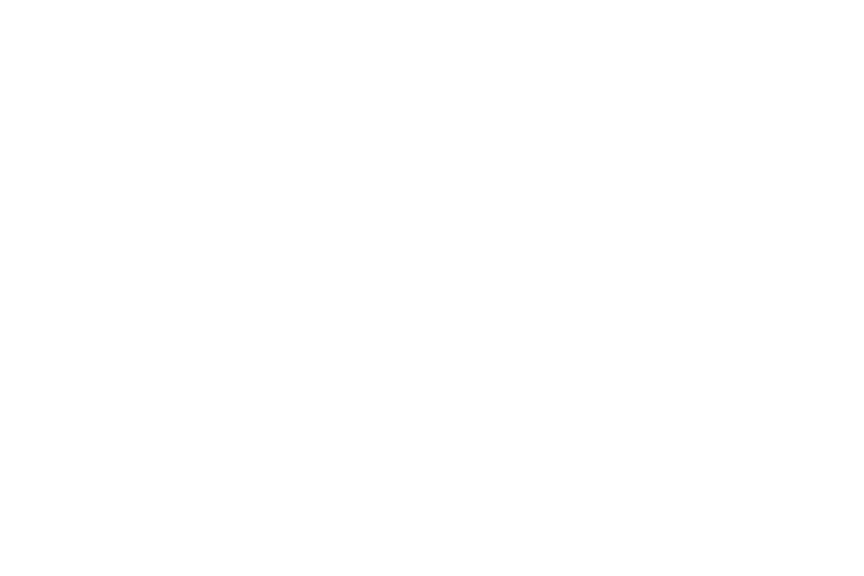

NameError: name 'trajectory2' is not defined

<IPython.core.display.Javascript object>


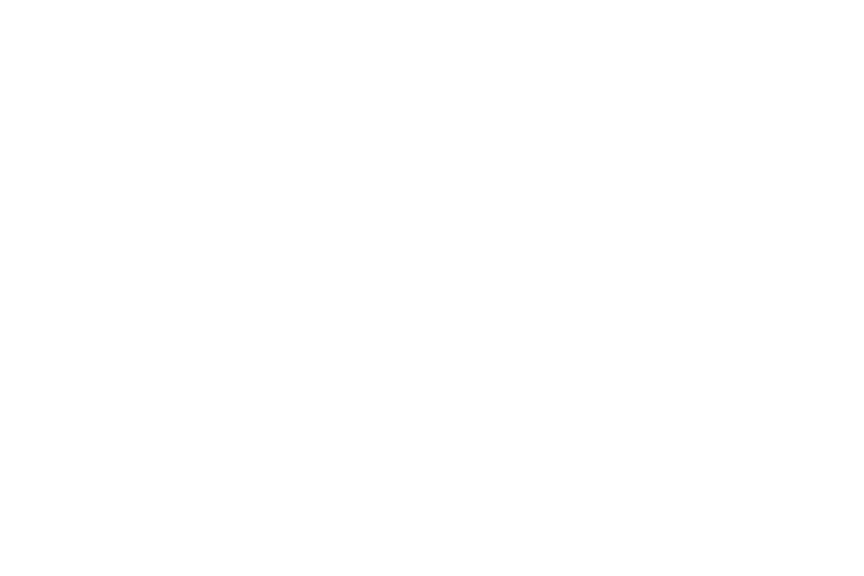

In [424]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory2[:, :, 3][:, 0], 
        trajectory2[:, :, 3][:, 1], 
        trajectory2[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [205]:
# These results are about the same. We need more speed as well as accuracy

In [ ]:
# We can see that we have as many lidar scans as we do image frames

In [222]:
file_name = './dataset/sequences/00/velodyne/000000.bin'

In [216]:
pointcloud = np.fromfile(file_name, dtype=np.float32, count=-1).reshape([-1,4])
pointcloud[:5]

array([[5.2897942e+01, 2.2989739e-02, 1.9979945e+00, 7.9999998e-02],
       [5.3750526e+01, 1.9291429e-01, 2.0269539e+00, 0.0000000e+00],
       [5.3803116e+01, 3.6183926e-01, 2.0289137e+00, 0.0000000e+00],
       [7.2600662e+01, 1.2964664e+00, 2.6647117e+00, 0.0000000e+00],
       [7.2118256e+01, 1.5133761e+00, 2.6476634e+00, 0.0000000e+00]],
      dtype=float32)

In [105]:
import mayavi.mlab

multiple 'tvtk.toolkits' plugins found for toolkit 'qt4': tvtk.pyface.ui.qt4.init, tvtk.pyface.ui.qt4.init


In [106]:
handler.pointclouds

[array([[ 5.2897942e+01,  2.2989739e-02,  1.9979945e+00,  7.9999998e-02],
        [ 5.3750526e+01,  1.9291429e-01,  2.0269539e+00,  0.0000000e+00],
        [ 5.3803116e+01,  3.6183926e-01,  2.0289137e+00,  0.0000000e+00],
        ...,
        [ 3.8401384e+00, -1.4381756e+00, -1.7735560e+00,  3.4000000e-01],
        [ 3.8257158e+00, -1.4192016e+00, -1.7645701e+00,  2.5000000e-01],
        [ 4.0923753e+00, -1.5071962e+00, -1.8955611e+00,  0.0000000e+00]],
       dtype=float32),
 array([[ 5.2305943e+01,  2.2989707e-02,  1.9779946e+00,  0.0000000e+00],
        [ 5.3259735e+01,  1.0695236e-01,  2.0099745e+00,  0.0000000e+00],
        [ 5.3284321e+01,  2.7487758e-01,  2.0109341e+00,  0.0000000e+00],
        ...,
        [ 3.8249431e+00, -1.4261885e+00, -1.7655631e+00,  2.3000000e-01],
        [ 3.8495324e+00, -1.4222100e+00, -1.7755738e+00,  2.8999999e-01],
        [ 3.8631279e+00, -1.4142324e+00, -1.7805853e+00,  0.0000000e+00]],
       dtype=float32),
 array([[ 5.2575943e+01,  2.2989839e-0

In [175]:
pointcloud = handler.pointclouds[0]
print(pointcloud.shape)
x = pointcloud[:, 0]  # x position of point
y = pointcloud[:, 1]  # y position of point
z = pointcloud[:, 2]  # z position of point
r = pointcloud[:, 3]  # reflectance value of point
d = np.sqrt(x ** 2 + y ** 2)  # Map Distance from sensor
 
 
vals='height'
if vals == "height":
    col = z
else:
    col = d
 
fig = mayavi.mlab.figure(bgcolor=(0, 0, 0), size=(640, 500))
mayavi.mlab.points3d(x, y, z,
                     col,          # Values used for Color
                     mode="point",
                     colormap='spectral', # 'bone', 'copper', 'gnuplot'
                     # color=(0, 1, 0),   # Used a fixed (r,g,b) instead
                     figure=fig,
                     )
 
x=np.linspace(5,5,50)
y=np.linspace(0,0,50)
z=np.linspace(0,5,50)
mayavi.mlab.plot3d(x,y,z)
mayavi.mlab.show()

(124668, 4)


In [176]:
render_points.shape

(124668, 4)

In [177]:
pointcloud.shape

(124668, 4)

In [224]:
projection_points = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
projection_xyz = handler.Tr.dot(projection_points.T)
projection_xyz.shape

(3, 124668)

In [209]:
# Euclidean distance depth measure
#depth = np.sqrt(projection_xyz[0] **2 + projection_xyz[1]**2 + projection_xyz[2]**2)
# Z depth measure
depth = projection_xyz[2]
projection_xyz = np.vstack([projection_xyz, np.ones(projection.shape[1])])
projection = handler.P0.dot(projection_xyz)
projection = (projection / projection[2])
projection.shape
#plt.imshow(projection[:2])

(3, 124668)

In [210]:
depth.shape

(124668,)

In [211]:
handler.images_left[0].shape

(376, 1241, 3)

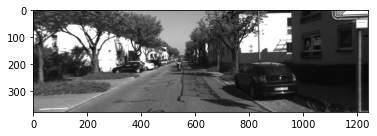

In [212]:
plt.imshow(handler.images_left[0])

In [213]:
pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
print(pixel_coordinates[:5])

[[607 152]
 [605 152]
 [602 152]
 [594 153]
 [592 153]]


In [251]:
[test_pix[:, 0] < imwidth & test_pix[:, 0] >= 0]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [252]:
print('Length of pixel coordinates:', len(pixel_coordinates))
test_pix = np.array(pixel_coordinates)
test_pix = test_pix[test_pix[:, 0] < imwidth]
test_pix = test_pix[test_pix[:, 0] >= 0]
test_pix = test_pix[test_pix[:, 1] < imheight]
test_pix = test_pix[test_pix[:, 1] >= 0]
print('Length of test pix:', len(test_pix))

Length of pixel coordinates: 124668
Length of test pix: 39539


In [214]:
np.min(pixel_coordinates)

-61009979

In [215]:
imheight = handler.images_left[0].shape[0]
imwidth = handler.images_left[0].shape[1]
render = np.zeros((imheight, imwidth))

for i, (u, v) in enumerate(pixel_coordinates):
    if u >= imwidth or u < 0:
        continue
    if v >= imheight or v < 0:
        continue
    render[v, u] = pointcloud[i, 3]

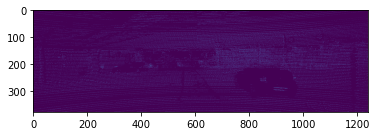

In [216]:
plt.imshow(render)

In [253]:
# This was the reflective intensity, not actually depth, interesting to look at though
render = np.zeros((imheight, imwidth))
i = 0
for i, (u, v) in enumerate(pixel_coordinates):
    i += 1
    if u >= imwidth or u < 0:
        continue
    if v >= imheight or v < 0:
        continue
    render[v, u] = depth[i]
    
print('Looped {} times'.format(i))

Looped 124668 times


In [254]:
# This was the reflective intensity, not actually depth, interesting to look at though
render = np.zeros((imheight, imwidth))
i = 0
for i, (u, v) in enumerate(test_pix):
    i += 1
    if u >= imwidth or u < 0:
        continue
    if v >= imheight or v < 0:
        continue
    render[v, u] = depth[i]
    
print('Looped {} times'.format(i))

Looped 39539 times


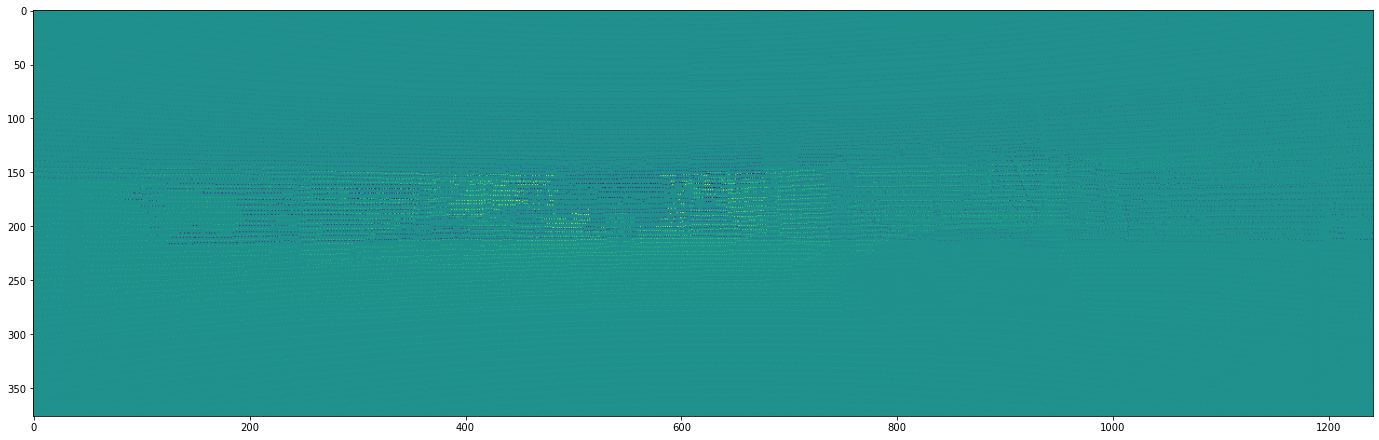

In [218]:
plt.figure(figsize=(24,12))
plt.imshow(render)

In [219]:
render[-1,-1]

0.0

In [220]:
# We can see a lot of gaps in this information
sum(sum(render == 0)) / render.size

0.9165009343871621

In [221]:
# We can see that this depth map is 91.6% empty space!

In [222]:
# Let's place the empty pixels in the far background
render2 = render.copy()
render2[render2 == 0.0] = 4000

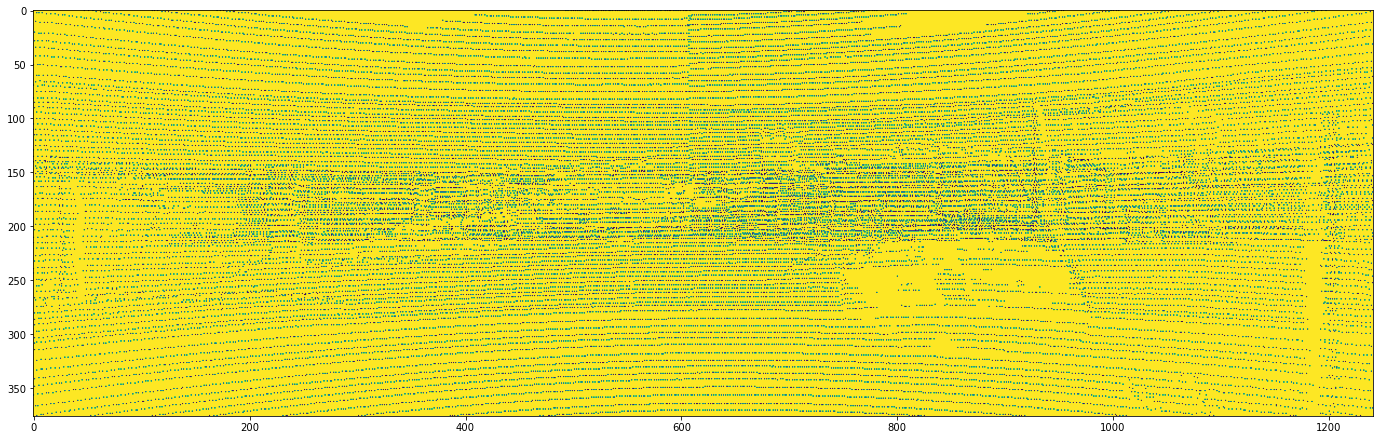

In [223]:
plt.figure(figsize=(24,10))
plt.imshow(render2)

In [ ]:
# Although this information is very sparse, it may be enough to use if we have enough feature
# matches to choose from

In [2]:
import re

cv_info = [re.sub('\s+', ' ', ci.strip()) for ci in cv2.getBuildInformation().strip().split('\n') 
               if len(ci) > 0 and re.search(r'(nvidia*:?)|(cuda*:)|(cudnn*:)', ci.lower()) is not None]
print(cv_info)

['Extra dependencies: cudart_static.lib nppc.lib nppial.lib nppicc.lib nppicom.lib nppidei.lib nppif.lib nppig.lib nppim.lib nppist.lib nppisu.lib nppitc.lib npps.lib cublas.lib cudnn.lib cufft.lib -LIBPATH:C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.1/lib/x64', 'NVIDIA CUDA: YES (ver 10.1, CUFFT CUBLAS FAST_MATH)', 'NVIDIA GPU arch: 61', 'NVIDIA PTX archs:', 'cuDNN: YES (ver 8.0.5)']


In [3]:
cv2.cuda.getCudaEnabledDeviceCount()

1

## Showing that arithmetic strategy faster than dot product:

In [85]:
start = datetime.datetime.now()
cx = k0[0, 2]
cy = k0[1, 2]
fx = k0[0, 0]
fy = k0[1, 1]
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
    #    print(z)
        delete.append(i)
        continue
    #else:
    #    print(u,v)
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    object_points = np.vstack([object_points, np.array([x, y, z])])
    #object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.023064
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [86]:
start = datetime.datetime.now()
delete = []
object_points = np.zeros((0, 3))
image1_points = np.float32([kp0[m.queryIdx].pt for m in matches])
for i, (u, v) in enumerate(image1_points):
    z = depth[int(v), int(u)]
    if z > 3000:
    #    print(z)
        delete.append(i)
        continue
    #else:
    #    print(u,v)
    x = z*(u-cx)/fx
    y = z*(v-cy)/fy
    #object_points = np.vstack([object_points, np.array([x, y, z])])
    object_points = np.vstack([object_points, np.linalg.inv(k0).dot(z*np.array([u, v, 1]))])
end = datetime.datetime.now()
print('Time to compute:', end-start)
print(object_points)

Time to compute: 0:00:00.077188
[[  3.50461848  -2.25380255  48.2681    ]
 [ -5.9355166   -4.52124313  29.70344615]
 [-13.00586866  -1.1806672   31.52202449]
 ...
 [ -1.86770698   0.60537074  25.32097049]
 [ -0.20512125   1.47857621  16.08936667]
 [  1.56142055   1.54149227  15.33081092]]


In [94]:
np.linalg.inv(k0).dot(np.append(np.array(kp0[0].pt), 1))

array([-0.84012126, -0.08929163,  1.        ])

In [97]:
test_point = np.array([1,2,3,1])
projected_point = P0.dot(test_point)
projected_point

array([2540.4344, 1993.3591,    3.    ])

In [98]:
projected_point / projected_point[2]

array([846.81146667, 664.45303333,   1.        ])

In [104]:
t0

array([[0.],
       [0.],
       [0.],
       [1.]])

In [108]:
transformed_point = np.hstack([r0, t0[:3]]).dot(test_point)
transformed_point / transformed_point[2]

array([846.81146667, 664.45303333,   1.        ])

In [118]:
xprime = np.hstack([r1, t1[:3]]).dot(test_point)
xprime / xprime[2]

array([0.51238857, 0.66666667, 1.        ])

In [119]:
transformed_point.dot(rotations.skew_symmetric(t1).dot(xprime))

-2.220446049250313e-16

In [204]:
start = datetime.datetime.now()
trajectory = visual_odometry(handler,
                             filter_match_distance=0.5, 
                             detector='sift',
                             #matching='FLANN',
                             mask=mask,
                             lidar=False,      
                             subset=2)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.519001
Time to compute frame 2: 0:00:00.500999
Time to perform odometry: 0:00:01.023999


In [133]:
T3 = trajectory[1]
T3

array([[ 0.99999081, -0.00260322, -0.00340773, -0.00243181],
       [ 0.00259639,  0.99999461, -0.00200929, -0.00730389],
       [ 0.00341294,  0.00200043,  0.99999218,  0.66789502]])

In [136]:
print(P1)

[[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]]


In [135]:
P3 = k0.dot(T3)
print(P3)

[[ 7.20921705e+02 -6.56696924e-01  6.04738381e+02  4.03792930e+02]
 [ 2.49855774e+00  7.19222636e+02  1.83769858e+02  1.18454199e+02]
 [ 3.41294366e-03  2.00042737e-03  9.99992175e-01  6.67895022e-01]]


In [234]:
filter_distance = 0.2
img1 = handler.images_left[0]
img2 = handler.images_left[1]
img3 = handler.images_left[2]
kp1, des1 = extract_features(img1, 'sift', None)
kp2, des2 = extract_features(img2, 'sift', None)
kp3, des3 = extract_features(img3, 'sift', None)
matches21 = match_features(des1, des2, matching='BF', detector='sift', sort=False)
matches31 = match_features(des1, des3, matching='BF', detector='sift', sort=False)
matches21 = filter_matches_distance(matches21, filter_distance)
matches31 = filter_matches_distance(matches31, filter_distance)
image12_points = np.float32([kp1[m.queryIdx].pt for m in matches21])
image21_points = np.float32([kp2[m.trainIdx].pt for m in matches21])
image13_points = np.float32([kp1[m.queryIdx].pt for m in matches31])
image31_points = np.float32([kp3[m.trainIdx].pt for m in matches31])
shared12 = np.where((image12_points[:,None] == image13_points).all(2).any(1))[0]
shared13 = np.where((image13_points[:,None] == image12_points).all(2).any(1))[0]
len(shared12)/image12_points.shape[0]

0.20710059171597633

In [245]:
print(shared12.shape)

(35,)


In [246]:
print(shared13.shape)

(31,)


In [272]:
shared12

array([  4,   6,  26,  32,  33,  40,  41,  42,  43,  46,  47,  67,  68,
        75,  76,  80,  81,  83,  89,  90, 102, 103, 104, 112, 113, 116,
       119, 128, 147, 150, 151, 153, 157, 163, 164], dtype=int64)

In [281]:
new_array = [tuple(row) for row in image12_points[shared12]]
uniques1 = np.array(np.unique(new_array, axis=0))
len(uniques1)

29

In [282]:
new_array = [tuple(row) for row in image21_points[shared12]]
uniques2 = np.array(np.unique(new_array, axis=0))
len(uniques2)

29

In [283]:
new_array = [tuple(row) for row in image31_points[shared13]]
uniques3 = np.array(np.unique(new_array, axis=0))
len(uniques3)

29

In [235]:
# We can see that half the points matched between images 1 and 2 are also shared between
# images 1 and 3, meaning they also have correspondences in image 2
#image1_points = image12_points[shared12]
#image2_points = image21_points[shared12]
#image3_points = image31_points[shared13]

In [302]:
image1_points = uniques1
image2_points = uniques2
image3_points = uniques3

In [303]:
for impoints in [image1_points, image2_points, image3_points]:
    print(impoints.shape)
    for row in impoints:
        print(row)
    print('----------')

(29, 2)
[178.37082 195.63423]
[227.83524 301.57208]
[329.9041 138.8264]
[374.7422  166.07578]
[393.33337 224.58093]
[395.92563 210.96161]
[396.32446 214.18588]
[401.57394 120.01039]
[430.0949 214.145 ]
[485.4401  206.26613]
[495.31512 176.61775]
[522.8706  187.39815]
[529.0751  145.49377]
[533.5948   92.43304]
[538.6521  156.41911]
[572.81256 126.61474]
[576.7137  186.46571]
[588.4582  111.89793]
[589.9853 190.9653]
[602.31036 162.54684]
[604.8117  153.92473]
[645.44257 281.4728 ]
[802.5036  143.18896]
[807.2898  149.84908]
[810.723   130.80998]
[867.8416  152.40143]
[898.79333 144.86232]
[931.9944  142.36864]
[935.18207 135.91174]
----------
(29, 2)
[168.7687  198.67067]
[205.01611 312.5679 ]
[327.11374 140.54053]
[372.88745 168.08647]
[389.91168 227.89418]
[392.4887 214.0099]
[392.95737 217.26283]
[398.06247 120.4761 ]
[428.30432 217.16951]
[486.12128 208.58919]
[497.09525 178.5789 ]
[524.5759  189.23273]
[530.94525 147.0096 ]
[534.36383  92.90618]
[540.6574  157.95325]
[574.80225 12

In [396]:
keep = 20
img1_points = np.hstack([image1_points, np.ones(image1_points.shape[0]).reshape(-1,1)])
img2_points = np.hstack([image2_points, np.ones(image2_points.shape[0]).reshape(-1,1)])
img3_points = np.hstack([image3_points, np.ones(image3_points.shape[0]).reshape(-1,1)])
E21 = cv2.findEssentialMat(image1_points[:keep], image2_points[:keep], k0)[0]
E31 = cv2.findEssentialMat(image1_points[:keep], image3_points[:keep], k0)[0]
_, rmat21, tvec21, mask21 = cv2.recoverPose(E=E21, 
                                            points1=image1_points[:keep], 
                                            points2=image2_points[:keep], 
                                            cameraMatrix=k0
                                           )
_, rmat31, tvec31, mask31 = cv2.recoverPose(E=E31, 
                                            points1=image1_points[:keep], 
                                            points2=image3_points[:keep], 
                                            cameraMatrix=k0)
P2 = k0.dot(np.hstack([rmat21, tvec21]))
P3 = k0.dot(np.hstack([rmat31, tvec31]))

In [293]:
keep = 29
img1_points = np.hstack([image1_points, np.ones(image1_points.shape[0]).reshape(-1,1)])
img2_points = np.hstack([image2_points, np.ones(image2_points.shape[0]).reshape(-1,1)])
img3_points = np.hstack([image3_points, np.ones(image3_points.shape[0]).reshape(-1,1)])
E21 = cv2.findEssentialMat(image1_points[:keep], image2_points[:keep], k0)[0]
E31 = cv2.findEssentialMat(image1_points[:keep], image3_points[:keep], k0)[0]
_, rmat21, tvec21, mask21 = cv2.recoverPose(E=E21, 
                                            points1=image1_points[:keep], 
                                            points2=image2_points[:keep], 
                                            cameraMatrix=k0
                                           )
_, rmat31, tvec31, mask31 = cv2.recoverPose(E=E31, 
                                            points1=image1_points[:keep], 
                                            points2=image3_points[:keep], 
                                            cameraMatrix=k0)
P2 = k0.dot(np.hstack([rmat21, tvec21]))
P3 = k0.dot(np.hstack([rmat31, tvec31]))

In [299]:
rmat31

array([[ 0.99996999,  0.00154958,  0.00759066],
       [-0.00157374,  0.99999371,  0.0031787 ],
       [-0.00758568, -0.00319055,  0.99996614]])

In [301]:
tvec21

array([[ 0.05927211],
       [-0.00652   ],
       [-0.99822057]])

In [300]:
tvec31

array([[-0.01432011],
       [ 0.01342696],
       [-0.99980731]])

In [390]:
# Attempt at trifocal tensor metric reconstruction:
P1 = handler.P0
#P2 = handler.P0
K1 = k0
K2 = k0
K3 = k0
a = rotations.skew_symmetric(P2[:,3])
A = P2[:,:3]
b = rotations.skew_symmetric(P3[:,3])
B = P3[:,:3]
F21 = a.dot(A)
F31 = b.dot(B)
#F21 = cv2.findFundamentalMat(image1_points, image2_points, cv2.FM_8POINT)[0]
#F31 = cv2.findFundamentalMat(image1_points, image3_points, cv2.FM_8POINT)[0]
E21 = K2.T.dot(F21).dot(K1)
E31 = K3.T.dot(F31).dot(K1)
#E21 = cv2.findEssentialMat(image1_points, image2_points, k0)[0]
#E31 = cv2.findEssentialMat(image1_points, image3_points, k0)[0]
#x1 = np.linalg.inv(K1).dot(np.append(image1_points[0], 1))
#x2 = np.linalg.inv(K2).dot(np.append(image2_points[0], 1))
#x3 = np.linalg.inv(K3).dot(np.append(image3_points[0], 1))
x1 = np.append(image1_points[0], 1)
x2 = np.append(image2_points[0], 1)
x3 = np.append(image3_points[0], 1)
#n = image1_points.shape[0]
#x1 = np.vstack([image1_points.T, np.ones(n)])
#x2 = np.vstack([image2_points.T, np.ones(n)])
#x3 = np.vstack([image3_points.T, np.ones(n)])

def get_P_E(E, K, x):
    U, S, Vt = np.linalg.svd(E)
    V = Vt.T
    if np.linalg.det(U)<0:
        U = -U
    if np.linalg.det(V)<0:
        Vt = (-V).T
    
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]
                 ])
    R = U.dot(W).dot(Vt)
    print(R)
    t = U[:,2]
    
    def getMandX1(Ri):
        M = rotations.skew_symmetric(Ri.T.dot(t))
        X1 = M.dot(np.linalg.inv(K1)).dot(x1)
        return M, X1
    
    M, X1 = getMandX1(R)
    Xprime = M.dot(R.T).dot(np.linalg.inv(K)).dot(x)
    
    if X1[2].dot(Xprime[2]) < 0:
        R = U.dot(W.T).dot(Vt)
        M, X1 = getMandX1(R)
        
    if X1[2].mean() < 0:
        t = -t
        
    P_E = K.dot(np.hstack([R, t.reshape(-1,1)]))
    return P_E

Ps = []
for E, K, x in zip([E21, E31], [K2, K3], [x2, x3]):
    Ps.append(get_P_E(E, K, x))

[[ 0.80683599 -0.05570814  0.58814308]
 [-0.07577959  0.97756093  0.19655048]
 [-0.58589516 -0.20315324  0.7845098 ]]
[[ 0.7616202  -0.0709607   0.64412674]
 [-0.06257213  0.9812889   0.18209017]
 [-0.64499566 -0.17898793  0.74292928]]


In [397]:
# Attempt at trifocal tensor metric reconstruction:
P1 = handler.P0
#P2 = handler.P0
K1 = k0
K2 = k0
K3 = k0
def trifocal(P1, P2, P3, i):
    a = rotations.skew_symmetric(P2[:,3])
    A = P2[:,:3]
    b = rotations.skew_symmetric(P3[:,3])
    B = P3[:,:3]
    F21 = a.dot(A)
    F31 = b.dot(B)
    #F21 = cv2.findFundamentalMat(image1_points, image2_points, cv2.FM_8POINT)[0]
    #F31 = cv2.findFundamentalMat(image1_points, image3_points, cv2.FM_8POINT)[0]
    E21 = K2.T.dot(F21).dot(K1)
    E31 = K3.T.dot(F31).dot(K1)
    #E21 = cv2.findEssentialMat(image1_points, image2_points, k0)[0]
    #E31 = cv2.findEssentialMat(image1_points, image3_points, k0)[0]
    #x1 = np.linalg.inv(K1).dot(np.append(image1_points[0], 1))
    #x2 = np.linalg.inv(K2).dot(np.append(image2_points[0], 1))
    #x3 = np.linalg.inv(K3).dot(np.append(image3_points[0], 1))
    x1 = np.append(image1_points[i], 1)
    x2 = np.append(image2_points[i], 1)
    x3 = np.append(image3_points[i], 1)
    #n = image1_points.shape[0]
    #x1 = np.vstack([image1_points.T, np.ones(n)])
    #x2 = np.vstack([image2_points.T, np.ones(n)])
    #x3 = np.vstack([image3_points.T, np.ones(n)])

    def get_P_E(E, K, x):
        U, S, Vt = np.linalg.svd(E)
        V = Vt.T
        if np.linalg.det(U)<0:
            U = -U
        if np.linalg.det(V)<0:
            Vt = (-V).T

        W = np.array([[0, -1, 0],
                      [1, 0, 0],
                      [0, 0, 1]
                     ])
        R = U.dot(W).dot(Vt)
        print(R)
        t = U[:,2]

        def getMandX1(Ri):
            M = rotations.skew_symmetric(Ri.T.dot(t))
            X1 = M.dot(np.linalg.inv(K1)).dot(x1)
            return M, X1

        M, X1 = getMandX1(R)
        Xprime = M.dot(R.T).dot(np.linalg.inv(K)).dot(x)

        if X1[2]*(Xprime[2]) < 0:
            R = U.dot(W.T).dot(Vt)
            M, X1 = getMandX1(R)

        if X1[2] < 0:
            t = -t

        P_E = K.dot(np.hstack([R, t.reshape(-1,1)]))
        return P_E

    Ps = []
    for E, K, x in zip([E21, E31], [K2, K3], [x2, x3]):
        Ps.append(get_P_E(E, K, x))

    return Ps[0], Ps[1]

for i in range(image1_points.shape[0]):
    P2, P3 = trifocal(P1, P2, P3, i)

[[-0.92338351 -0.00488524 -0.38384767]
 [ 0.12606267 -0.948324   -0.29118687]
 [-0.36258944 -0.31726602  0.87628259]]
[[ 0.6956765  -0.09119344  0.71254331]
 [-0.03254194  0.98689044  0.15807685]
 [-0.71761775 -0.13315789  0.68358887]]
[[ 0.54588852 -0.11024055  0.83057374]
 [ 0.01920517  0.99269221  0.11913579]
 [-0.83763768 -0.04908355  0.54401647]]
[[-0.83623682  0.04826969 -0.54623988]
 [ 0.09798065 -0.96693642 -0.23544373]
 [-0.53954403 -0.25040766  0.80385835]]
[[ 0.54588745 -0.11024066  0.83057443]
 [ 0.01920511  0.9926922   0.11913587]
 [-0.83763838 -0.0490835   0.5440154 ]]
[[-0.83623626  0.04826983 -0.54624074]
 [ 0.09798086 -0.96693638 -0.23544381]
 [-0.53954488 -0.25040778  0.80385774]]
[[-0.92303148 -0.00480187 -0.38469447]
 [ 0.12626244 -0.94831935 -0.29111545]
 [-0.36341531 -0.31728118  0.87593491]]
[[ 0.69514178 -0.09130873  0.71305022]
 [-0.03263183  0.98687019  0.15818467]
 [-0.71813165 -0.13322891  0.68303513]]
[[ 0.54588745 -0.11024066  0.83057443]
 [ 0.01920511  0.

In [404]:
k_test, r_test, t_test, _, _, _, _ = cv2.decomposeProjectionMatrix(P3)
r_test

array([[ 0.69514178, -0.09130873,  0.71305022],
       [-0.03263183,  0.98687019,  0.15818467],
       [-0.71813165, -0.13322891,  0.68303513]])

In [405]:
t_test

array([[ 0.44804135],
       [ 0.13666877],
       [-0.52969859],
       [ 0.70710678]])

In [391]:
for P in Ps:
    print(P)

[[ 2.24247573e+02 -1.63399318e+02  8.99138885e+02  5.63504233e+02]
 [-1.62991598e+02  6.65098366e+02  2.86595022e+02  1.89573064e+02]
 [-5.85895157e-01 -2.03153245e-01  7.84509798e-01  9.98220570e-01]]
[[ 1.55858530e+02 -1.59690707e+02  9.14135680e+02  6.17369897e+02]
 [-1.64443673e+02  6.72254037e+02  2.68498776e+02  1.75527960e+02]
 [-6.44995659e-01 -1.78987929e-01  7.42929284e-01  9.99807307e-01]]


In [392]:
k_test, r_test, t_test, _, _, _, _ = cv2.decomposeProjectionMatrix(Ps[0])
#t_test = t_test / t_test[3]
print(k_test)
print(r_test)
print(t_test)

[[7.18856000e+02 3.17844597e-13 6.07192800e+02]
 [0.00000000e+00 7.18856000e+02 1.85215700e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.80683599 -0.05570814  0.58814308]
 [-0.07577959  0.97756093  0.19655048]
 [-0.58589516 -0.20315324  0.7845098 ]]
[[ 0.44771848]
 [ 0.13655371]
 [-0.53000117]
 [ 0.70710678]]


In [393]:
k_test2, r_test2, t_test2, _, _, _, _ = cv2.decomposeProjectionMatrix(Ps[0])
k_test3, r_test3, t_test3, _, _, _, _ = cv2.decomposeProjectionMatrix(Ps[1])
#t_test2 /= t_test2[3]
#t_test3 /= t_test3[3]
p2 = r_test2.T.dot(np.linalg.inv(k_test2)).dot(x2)
p3 = r_test3.T.dot(np.linalg.inv(k_test3)).dot(x3)
M = rotations.skew_symmetric(p2)
scale = (p3.T.dot(M).dot(r_test2.T).dot(t_test2[:3]))/(p3.T.dot(M).dot(r_test3.T).dot(t_test3[:3]))
scale

ValueError: setting an array element with a sequence.

In [383]:
t_test2

array([[-0.44771848],
       [-0.13655371],
       [ 0.53000117],
       [ 0.70710678]])

In [384]:
handler.gt[2]

array([[ 9.999910e-01,  1.048972e-03, -4.131348e-03, -9.374345e-02],
       [-1.058514e-03,  9.999968e-01, -2.308104e-03, -5.676064e-02],
       [ 4.128913e-03,  2.312456e-03,  9.999887e-01,  1.716275e+00]])

In [385]:
print(trajectory[1])

[[ 0.99999081 -0.00260322 -0.00340773 -0.00243181]
 [ 0.00259639  0.99999461 -0.00200929 -0.00730389]
 [ 0.00341294  0.00200043  0.99999218  0.66789502]]


In [386]:
t_test3*scale

array([[-0.44806667],
       [-0.13669026],
       [ 0.53047236],
       [ 0.70770679]])

In [387]:
print(trajectory[2])

[[ 9.99972256e-01 -1.10299657e-03 -7.36690565e-03 -1.68551122e-02]
 [ 1.07727115e-03  9.99993312e-01 -3.49508026e-03 -1.24412202e-02]
 [ 7.37071144e-03  3.48704714e-03  9.99966756e-01  1.35494238e+00]]


In [43]:
# I will import a helpful bit of code to help get this tranformation matrix
os.sys.path.append("C:/Coursera/Course2/Final Project")
import rotations